In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_curve, roc_auc_score, make_scorer, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

In [2]:
db_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021.csv'
df_departamentos = pd.read_csv(db_url)
df_departementos_complete = df_departamentos.copy()

df_departamentos_train = df_departamentos.copy()
df_departementos_complete_train = df_departamentos.copy()

# Procesamiento del Dataset  


Se crea un nuevo dataset el cual cumpla con los requisitos pedidos, los cuales son:
- El tipo de propiedad sea: Casa, Ph o Departamento
- Que se encuentre en Capital Federal
- Su precio se encuentre en dolares
- Que esté en venta

In [3]:
variable_name = ""
polygon_coords = [
    (-58.4576, -34.5265),
    (-58.5698, -34.6178),
    (-58.4609, -34.7051),
    (-58.3324, -34.6284)
]
buenos_aires_polygon = Polygon(polygon_coords)


vivienda_df = df_departementos_complete.copy()


vivienda_df = df_departementos_complete.loc[df_departementos_complete['property_type'].isin(['Casa', 'PH', 'Departamento'])]
vivienda_df.reset_index(drop=True, inplace=True)

vivienda_df.drop(vivienda_df[~(vivienda_df['place_l2'] == 'Capital Federal')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

geometry = [Point(lon, lat) for lon, lat in zip(vivienda_df['longitud'], vivienda_df['latitud'])]
gdf = gpd.GeoDataFrame(vivienda_df, geometry=geometry, crs="EPSG:4326")
en_buenos_aires = gdf.within(buenos_aires_polygon)

vivienda_df = vivienda_df[en_buenos_aires]

vivienda_df.drop(vivienda_df[~(vivienda_df['operation'] == 'Venta')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

vivienda_df.drop(vivienda_df[~(vivienda_df['property_currency'] == 'USD')].index, inplace=True)
vivienda_df.reset_index(drop=True, inplace=True)

tipos_property_currency = vivienda_df['property_currency'].value_counts()


vivienda_df.head(3)

<ipython-input-3-b41c3d3bf31d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vivienda_df.drop(vivienda_df[~(vivienda_df['place_l2'] == 'Capital Federal')].index, inplace=True)


id  start_date    end_date  created_on    latitud  \
0  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
1  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
2  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   

    longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
1 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
2 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             3.0                2.0                    58.0   
1  Departamento             4.0                3.0                    70.0   
2  Departamento             4.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                      55.0         82900.0               USD   
1                      70.0         99000.0               USD   
2                     104.0        146000.0               USD   

                               property_title  
0      VENTA TRES AMBIENTES LA BOCA PISO ALTO  
1  Departamento - 4 Ambientes - Catalinas Sur  
2         Venta departamento 4 ambientes Once

### Separamos en Test y Train

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
columnas_modelo = vivienda_df.columns.tolist()
columnas_modelo.remove('property_price')

ds_trabajo_x = vivienda_df[columnas_modelo].copy()
ds_trabajo_y = vivienda_df['property_price'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size=0.2, random_state=2)

In [6]:
vivienda_df = x_train.copy()

In [7]:
x_test_y_test = x_test.copy()

In [8]:
x_test_y_test['property_price'] = y_test.copy()

In [9]:
vivienda_df['property_price'] = y_train.copy()

## Preprocesamiento

Ya el dataset fue filtrado

In [10]:
print("cantidad de registros originales: " + str(df_departementos_complete.shape[0]))
print("cantidad de registros filtrados " + str(vivienda_df.shape[0]))

porcentaje = (
    (df_departementos_complete.shape[0] - vivienda_df.shape[0]) / df_departementos_complete.shape[0] * 100
)



cantidad de registros originales: 460154
cantidad de registros filtrados 71767


In [11]:
df_eliminar_nans = vivienda_df.copy()
filas_totales = df_eliminar_nans.shape[0]
print(df_eliminar_nans.isna().sum() / filas_totales * 100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       0.000000
longitud                      0.000000
place_l2                      0.000000
place_l3                      0.055736
place_l4                     96.396673
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                0.962838
property_bedrooms            11.537336
property_surface_total        5.021807
property_surface_covered      3.539231
property_currency             0.000000
property_title                0.000000
property_price                0.000000
dtype: float64


In [12]:
columnas_eliminar_NANs = ["place_l4", "place_l5", "place_l6"]
df_eliminar_nans.drop(columnas_eliminar_NANs, axis="columns", inplace=True)

In [13]:
x_test_y_test.drop(columnas_eliminar_NANs, axis="columns", inplace=True)

Se eliminan las columnas [place_l4, place_l5, place_l6] ya que el porcentaje de Nan es muy alto

In [14]:
filas_totales = df_eliminar_nans.shape[0]
print(df_eliminar_nans.isna().sum() / filas_totales * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.055736
operation                    0.000000
property_type                0.000000
property_rooms               0.962838
property_bedrooms           11.537336
property_surface_total       5.021807
property_surface_covered     3.539231
property_currency            0.000000
property_title               0.000000
property_price               0.000000
dtype: float64


In [15]:
df_filtrado = df_eliminar_nans.copy()

Ahora se lidia con algunos atributos vacios

Primero se completa las columnas vacias de "property_surface_total" y "property_surface_covered", ya que estas 2 estan estrechamente relacionadas

Se verifica que ninguna Propiedad tenga los dos atributos vacios

In [16]:
mask = df_filtrado['property_surface_total'].isna() & df_filtrado['property_surface_covered'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

0


In [17]:
mask_test = x_test_y_test['property_surface_total'].isna() & x_test_y_test['property_surface_covered'].isna()


filas_con_ambos_nan_test = mask_test.sum()
print(filas_con_ambos_nan_test)

0


Ahora se saca un promedio de la diferencia de tamaño que hay entre "property_surface_total" y "property_surface_covered"

In [18]:
promedio_surface_total = df_filtrado[['property_surface_total']].mean(skipna=True)
promedio_surface_covered = df_filtrado[['property_surface_covered']].mean(skipna=True)

promerdio_superficie = float(promedio_surface_total)/float(promedio_surface_covered)

Inputo "property_surface_total" si se encuentra null, multiplicando el promedio total por "promedio_surface_covered"

In [19]:
df_filtrado['property_surface_total'].fillna(df_filtrado['property_surface_covered'] * promerdio_superficie, inplace=True)

In [20]:
x_test_y_test['property_surface_total'].fillna(x_test_y_test['property_surface_covered'] * promerdio_superficie, inplace=True)

 Lo mimso con "property_surface_covered"

In [21]:
df_filtrado['property_surface_covered'].fillna(df_filtrado['property_surface_total'] / promerdio_superficie, inplace=True)

In [22]:
x_test_y_test['property_surface_covered'].fillna(x_test_y_test['property_surface_total'] / promerdio_superficie, inplace=True)

Se verifica que ninguno de los 2 atributos este vacio

In [23]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.055736
operation                    0.000000
property_type                0.000000
property_rooms               0.962838
property_bedrooms           11.537336
property_surface_total       0.000000
property_surface_covered     0.000000
property_currency            0.000000
property_title               0.000000
property_price               0.000000
dtype: float64


In [24]:
filas_totales_test = x_test_y_test.shape[0]
print(x_test_y_test.isna().sum() / filas_totales_test * 100)

id                           0.000000
start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.066882
operation                    0.000000
property_type                0.000000
property_rooms               0.941924
property_bedrooms           11.793557
property_surface_total       0.000000
property_surface_covered     0.000000
property_currency            0.000000
property_title               0.000000
property_price               0.000000
dtype: float64


Se corrige cuando property_surface_covered es mayor que property_surface_total, ya que no tiene sentido que se tenga un mayor terreno cubierto que el terreno total

Lo que se hace es intercambiar ambos valores, ya que se da a entender que se confundieron de parametros

In [25]:
propiedades_superficie_incorrecta = df_filtrado[df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']]


print(len(propiedades_superficie_incorrecta))

135


In [26]:
propiedades_superficie_incorrecta_test = x_test_y_test[x_test_y_test['property_surface_covered'] > x_test_y_test['property_surface_total']]


print(len(propiedades_superficie_incorrecta_test))

29


Gráfico de la cantidad de superficies incorrectas

In [27]:
propiedades_superficie_incorrecta['diferencia'] = propiedades_superficie_incorrecta['property_surface_covered'] - propiedades_superficie_incorrecta['property_surface_total']


promedio_diferencias = propiedades_superficie_incorrecta['diferencia'].mean()

total_propiedades_incorrectas = len(propiedades_superficie_incorrecta)
porcentaje_promedio = (promedio_diferencias / total_propiedades_incorrectas) * 100

<ipython-input-27-bc139dcd6e49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propiedades_superficie_incorrecta['diferencia'] = propiedades_superficie_incorrecta['property_surface_covered'] - propiedades_superficie_incorrecta['property_surface_total']


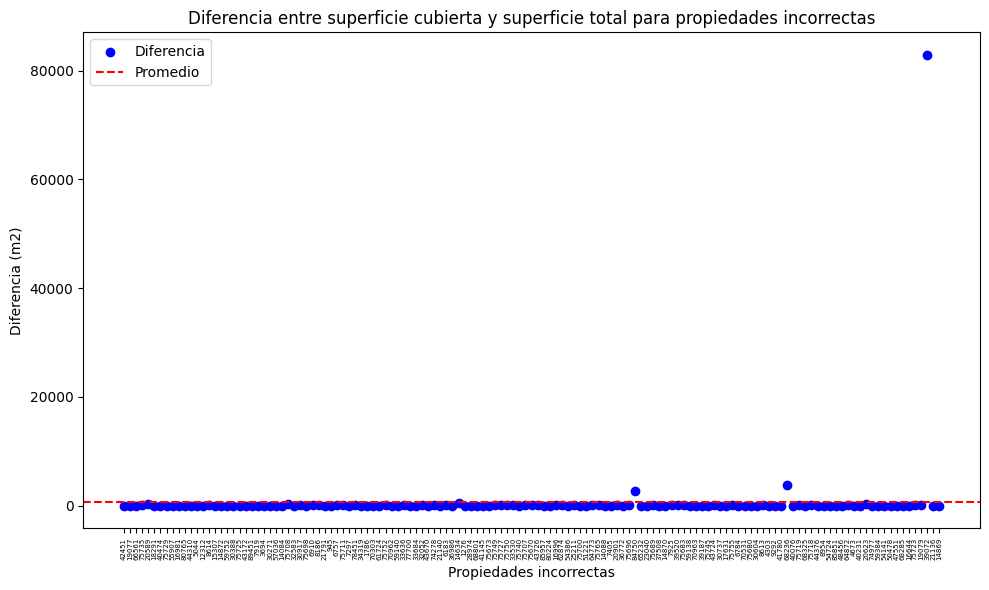

In [28]:
# Crear un gráfico de dispersión para mostrar la diferencia entre superficie cubierta y superficie total
plt.figure(figsize=(10, 6))
plt.scatter(range(len(propiedades_superficie_incorrecta)), propiedades_superficie_incorrecta['diferencia'], color='blue', label='Diferencia')
plt.axhline(promedio_diferencias, color='red', linestyle='--', label='Promedio')
plt.title('Diferencia entre superficie cubierta y superficie total para propiedades incorrectas')
plt.xlabel('Propiedades incorrectas')
plt.ylabel('Diferencia (m2)')
plt.legend()
plt.xticks(range(len(propiedades_superficie_incorrecta)), propiedades_superficie_incorrecta.index, rotation=90, fontsize=5)
plt.tight_layout()
plt.show()

In [29]:
propiedades_superficie_incorrecta_test['diferencia'] = propiedades_superficie_incorrecta_test['property_surface_covered'] - propiedades_superficie_incorrecta_test['property_surface_total']


promedio_diferencias_test = propiedades_superficie_incorrecta_test['diferencia'].mean()

total_propiedades_incorrectas_test = len(propiedades_superficie_incorrecta_test)
porcentaje_promedio_test = (promedio_diferencias_test / total_propiedades_incorrectas_test) * 100

<ipython-input-29-99abac6c178d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propiedades_superficie_incorrecta_test['diferencia'] = propiedades_superficie_incorrecta_test['property_surface_covered'] - propiedades_superficie_incorrecta_test['property_surface_total']


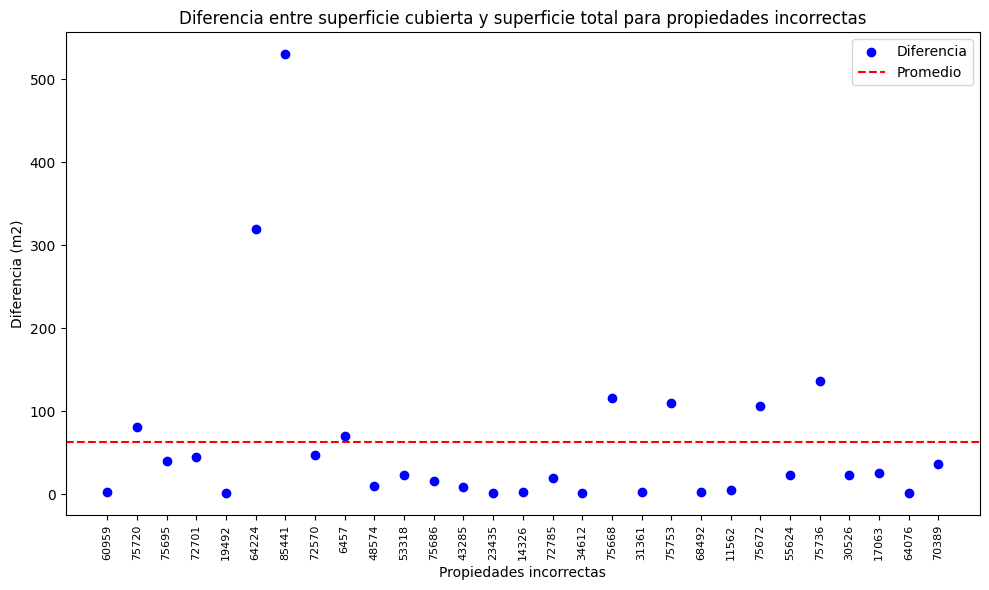

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(propiedades_superficie_incorrecta_test)), propiedades_superficie_incorrecta_test['diferencia'], color='blue', label='Diferencia')
plt.axhline(promedio_diferencias_test, color='red', linestyle='--', label='Promedio')
plt.title('Diferencia entre superficie cubierta y superficie total para propiedades incorrectas')
plt.xlabel('Propiedades incorrectas')
plt.ylabel('Diferencia (m2)')
plt.legend()
plt.xticks(range(len(propiedades_superficie_incorrecta_test)), propiedades_superficie_incorrecta_test.index, rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

Se ve que en su mayoria la diferencia de m2 de property_surface_covered y property_surface_total es baja,salvo por unos outsider, por lo tanto se deduce que se confundieorn de Campo al poner lso tamaños de la propiedad

Asi que lo que se va hacer es intercambiar ambos valores por cada propiedad incorrecta

In [31]:
mask = df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']


df_filtrado.loc[mask, ['property_surface_covered', 'property_surface_total']] = df_filtrado.loc[mask, ['property_surface_total', 'property_surface_covered']].values

propiedades_superficie_incorrecta = df_filtrado[df_filtrado['property_surface_covered'] > df_filtrado['property_surface_total']]

print(len(propiedades_superficie_incorrecta))

0


In [32]:
mask_test = x_test_y_test['property_surface_covered'] > x_test_y_test['property_surface_total']


x_test_y_test.loc[mask_test, ['property_surface_covered', 'property_surface_total']] = x_test_y_test.loc[mask_test, ['property_surface_total', 'property_surface_covered']].values

propiedades_superficie_incorrecta_test = x_test_y_test[x_test_y_test['property_surface_covered'] > x_test_y_test['property_surface_total']]

print(len(propiedades_superficie_incorrecta_test))

0


Se inputan los atributos rooms y bedrooms que esten Nan

Primero se comprueba que ninguna propiedad tiene ambos atributos en Nan

In [33]:
mask = df_filtrado['property_rooms'].isna() & df_filtrado['property_bedrooms'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

303


In [34]:
mask_test = x_test_y_test['property_rooms'].isna() & x_test_y_test['property_bedrooms'].isna()


filas_con_ambos_nan_test = mask_test.sum()
print(filas_con_ambos_nan_test)

62


Se borran las propiedades que tiene ambos atributos en Nan

In [35]:
df_filtrado = df_filtrado[~mask]


In [36]:
x_test_y_test = x_test_y_test[~mask_test]


Se calcula el promedio de property_bedrooms que hay dependiendo de property_rooms





In [37]:
promedio_rooms = df_filtrado[['property_rooms']].mean(skipna=True)
promedio_bedrooms = df_filtrado[['property_bedrooms']].mean(skipna=True)

promerdio = float(promedio_rooms)/float(promedio_bedrooms)
print(promerdio)

1.4047747140349442


In [38]:
promedio_rooms_test = x_test_y_test[['property_rooms']].mean(skipna=True)
promedio_bedrooms_test = x_test_y_test[['property_bedrooms']].mean(skipna=True)

promerdio_test = float(promedio_rooms_test)/float(promedio_bedrooms_test)
print(promerdio_test)

1.3963568319050406


Como en las propiedades por lo general hay 1.4 mas rooms que bedrooms, se hace la estimacion de que en la mayoria de propiedades hay un room mas bedrooms, debido que 1.4 tiende mas a uno que a dos, es decir el promedio es que por cada propiedad hay una room de mas comparado los bedrooms

Por lo tanto lo que se hace es buscar las propiedades con Rooms Nan, y inputarle la cantidad de ahbitaciones mas 1(Que nos dio en el promedio)

In [39]:
df_filtrado['property_rooms'].fillna(df_filtrado['property_bedrooms'] + 1, inplace=True)

In [40]:
x_test_y_test['property_rooms'].fillna(x_test_y_test['property_bedrooms'] + 1, inplace=True)

Ahora se verifica si hay property_rooms con valor 0

In [41]:
propiedades_con_cero_rooms = df_filtrado['property_rooms'] == 0
cantidad_propiedades_con_cero_rooms = propiedades_con_cero_rooms.sum()
print(cantidad_propiedades_con_cero_rooms)

0


In [42]:
propiedades_con_cero_rooms_test = x_test_y_test['property_rooms'] == 0
cantidad_propiedades_con_cero_rooms_test = propiedades_con_cero_rooms_test.sum()
print(cantidad_propiedades_con_cero_rooms_test)

0


Ahora propiedades con 1

In [43]:
propiedades_con_uno_rooms = df_filtrado['property_rooms'] == 1
cantidad_propiedades_con_uno_rooms = propiedades_con_uno_rooms.sum()
print(cantidad_propiedades_con_uno_rooms)

11439


In [44]:
propiedades_con_uno_rooms_test = x_test_y_test['property_rooms'] == 1
cantidad_propiedades_con_uno_rooms_test = propiedades_con_uno_rooms_test.sum()
print(cantidad_propiedades_con_uno_rooms_test)

2912


Se hace lo mismo pero con Bedrooms, exceptuando a las propiedades con un solo cuarto(monoambientes)

In [45]:
df_filtrado['property_bedrooms'].fillna(df_filtrado['property_rooms'] - 1, inplace=True)

df_filtrado.loc[df_filtrado['property_rooms'] == 1, 'property_bedrooms'] = 1

mask = df_filtrado['property_rooms'].isna() & df_filtrado['property_bedrooms'].isna()


filas_con_ambos_nan = mask.sum()
print(filas_con_ambos_nan)

0


In [46]:
x_test_y_test['property_bedrooms'].fillna(x_test_y_test['property_rooms'] - 1, inplace=True)

x_test_y_test.loc[x_test_y_test['property_rooms'] == 1, 'property_bedrooms'] = 1

mask_test = x_test_y_test['property_rooms'].isna() & x_test_y_test['property_bedrooms'].isna()


filas_con_ambos_nan_test = mask_test.sum()
print(filas_con_ambos_nan_test)

0


Se verifica que no haya 0 dormitorios

In [47]:
propiedades_con_cero_bedrooms = df_filtrado['property_bedrooms'] == 0
cantidad_propiedades_con_cero_bedrooms = propiedades_con_cero_bedrooms.sum()
print(cantidad_propiedades_con_cero_bedrooms)

0


In [48]:
propiedades_con_cero_bedrooms_test = x_test_y_test['property_bedrooms'] == 0
cantidad_propiedades_con_cero_bedrooms_test = propiedades_con_cero_bedrooms_test.sum()
print(cantidad_propiedades_con_cero_bedrooms_test)

0


Se verifica que no haya ninguna propiedad con menos de 0 cuartos

In [49]:
cuartos_negativos = df_filtrado['property_rooms'] < 0

cantidad_propiedades_negativas = cuartos_negativos.sum()

print("Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms':", cantidad_propiedades_negativas)

Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms': 0


In [50]:
cuartos_negativos_test = x_test_y_test['property_rooms'] < 0

cantidad_propiedades_negativas_test = cuartos_negativos_test.sum()

print("Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms':", cantidad_propiedades_negativas_test)

Cantidad de propiedades con valores menores a 0 en la columna 'property_rooms': 0


Que no haya ninguna propiedad con menos de 0 dormitorios

In [51]:
mask_test = x_test_y_test['property_bedrooms'] < 0

x_test_y_test.loc[mask_test, 'property_bedrooms'] = x_test_y_test.loc[mask_test, 'property_rooms'] - 1
#se verica los cambios
dormitorios_negativos_test = x_test_y_test['property_bedrooms'] <0
cantidad_propiedades_negativas_test = dormitorios_negativos_test.sum()
print("Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms':", cantidad_propiedades_negativas_test)

Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms': 0


In [52]:
mask = df_filtrado['property_bedrooms'] < 0

df_filtrado.loc[mask, 'property_bedrooms'] = df_filtrado.loc[mask, 'property_rooms'] - 1
#se verica los cambios
dormitorios_negativos = df_filtrado['property_bedrooms'] <0
cantidad_propiedades_negativas = dormitorios_negativos.sum()
print("Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms':", cantidad_propiedades_negativas)

Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms': 0


In [53]:
mask_test = x_test_y_test['property_bedrooms'] < 0

x_test_y_test.loc[mask_test, 'property_bedrooms'] = x_test_y_test.loc[mask_test, 'property_rooms'] - 1
#se verica los cambios
dormitorios_negativos_test = x_test_y_test['property_bedrooms'] <0
cantidad_propiedades_negativas_test = dormitorios_negativos_test.sum()
print("Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms':", cantidad_propiedades_negativas_test)

Cantidad de propiedades con valores menores a 0 en la columna 'property_Bedrooms': 0


Se busca que no haya mas dormitorios que habitaciones

In [54]:
indices_correccion = df_filtrado[df_filtrado['property_bedrooms'] > df_filtrado['property_rooms']].index

df_filtrado.loc[indices_correccion, 'property_bedrooms'] = df_filtrado.loc[indices_correccion, 'property_rooms']

indices_correccion_despues = df_filtrado[df_filtrado['property_bedrooms'] > df_filtrado['property_rooms']].index

print("Cantidad de filas corregidas:", len(indices_correccion_despues))


Cantidad de filas corregidas: 0


In [55]:
indices_correccion_test = x_test_y_test[x_test_y_test['property_bedrooms'] > x_test_y_test['property_rooms']].index

x_test_y_test.loc[indices_correccion_test, 'property_bedrooms'] = x_test_y_test.loc[indices_correccion_test, 'property_rooms']

indices_correccion_despues_test = x_test_y_test[x_test_y_test['property_bedrooms'] > x_test_y_test['property_rooms']].index

print("Cantidad de filas corregidas:", len(indices_correccion_despues_test))


Cantidad de filas corregidas: 0


Siempre hay mas habitaciones que dormitorios

Se verifica devuelta si hay columnas Nan

In [56]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

id                          0.000000
start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     0.000000
longitud                    0.000000
place_l2                    0.000000
place_l3                    0.055972
operation                   0.000000
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_currency           0.000000
property_title              0.000000
property_price              0.000000
dtype: float64


In [57]:
filas_totales_test = x_test_y_test.shape[0]
print(x_test_y_test.isna().sum() / filas_totales_test * 100)

id                          0.000000
start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     0.000000
longitud                    0.000000
place_l2                    0.000000
place_l3                    0.067114
operation                   0.000000
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_currency           0.000000
property_title              0.000000
property_price              0.000000
dtype: float64


Como se puede ver hay un muy pequeño porcentaje de Propiedades sin barrio. Las cuales se van a borrar ya que no va a afectar al dataset.

In [58]:
df_filtrado = df_filtrado.dropna(subset=["place_l3"])

In [59]:
x_test_y_test = x_test_y_test.dropna(subset=["place_l3"])

Variables que no aportan nada:

-Id: Nunca se a requerir el uso de estas, y como se esta trabajando con conjunto de datos, no se va a necesitar el identificador de cada propiedad

-Created_on: Ya existe una variable que cumple la funcion de esta, la cual es Start_date

Se elimina estas 2 variables


In [60]:
df_filtrado["operation"].unique()

array(['Venta'], dtype=object)

In [61]:
df_filtrado["property_currency"].unique()

array(['USD'], dtype=object)

In [62]:
x_test_y_test["operation"].unique()

array(['Venta'], dtype=object)

In [63]:
x_test_y_test["property_currency"].unique()

array(['USD'], dtype=object)

In [64]:
columnas_a_eliminar = ["id", "created_on", "place_l2", "operation", "property_currency"]
df_filtrado = df_filtrado.drop(columnas_a_eliminar, axis=1)
df_filtrado.head(1)

start_date    end_date    latitud   longitud          place_l3  \
47437  2021-02-11  2021-03-18 -34.630337 -58.411793  Parque Patricios   

      property_type  property_rooms  property_bedrooms  \
47437  Departamento             2.0                1.0   

       property_surface_total  property_surface_covered  \
47437                   139.0                      61.0   

                                          property_title  property_price  
47437  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...        160000.0

In [65]:
x_test_y_test = x_test_y_test.drop(columnas_a_eliminar, axis=1)
x_test_y_test.head(1)

start_date    end_date    latitud   longitud    place_l3 property_type  \
77979  2021-09-07  2022-03-06 -34.572507 -58.447047  Colegiales  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
77979             3.0                2.0                    65.0   

       property_surface_covered  \
77979                      56.0   

                                          property_title  property_price  
77979  3 ambientes con vista totalmente abierta . Ent...        248000.0

In [66]:
filas_totales = df_filtrado.shape[0]
print(df_filtrado.isna().sum() / filas_totales * 100)

start_date                  0.0
end_date                    0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_title              0.0
property_price              0.0
dtype: float64


In [67]:
filas_totales_test = x_test_y_test.shape[0]
print(x_test_y_test.isna().sum() / filas_totales_test * 100)

start_date                  0.0
end_date                    0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_title              0.0
property_price              0.0
dtype: float64


In [68]:
#df_filtrado.to_csv("/tmp/properati_argentina_2021_train_XY_preprocesado.csv", index=False)

In [69]:
#x_test_y_test.to_csv("/tmp/properati_argentina_2021_test_XY_preprocesado.csv", index=False)

In [70]:
train_XY_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021_train_XY_preprocesado.csv'
df_train = pd.read_csv(train_XY_url)

In [71]:
df_train.head(5)

start_date    end_date    latitud   longitud          place_l3  \
0  2021-02-11  2021-03-18 -34.630337 -58.411793  Parque Patricios   
1  2021-12-16  2022-02-09 -34.637319 -58.361124              Boca   
2  2021-11-06  2022-01-27 -34.597205 -58.392474          Recoleta   
3  2021-03-30  2021-04-04 -34.590503 -58.408862           Palermo   
4  2021-06-27  9999-12-31 -34.579388 -58.436085           Palermo   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             2.0                1.0              139.000000   
1  Departamento             3.0                2.0               58.000000   
2  Departamento             3.0                2.0              133.000000   
3  Departamento             4.0                3.0               81.189696   
4  Departamento             1.0                1.0               25.000000   

   property_surface_covered  \
0                      61.0   
1                      55.0   
2                      92.0   
3                      67.0   
4                      20.0   

                                      property_title  property_price  
0  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...        160000.0  
1            VENTA TRES AMBIENTES LA BOCA PISO ALTO          74900.0  
2      Venta de Departamento 3 Ambientes en Recoleta        469200.0  
3                             Departamento - Palermo        212000.0  
4     Departamento Monoambiente en Palermo Hollywood        123000.0

In [72]:
test_XY_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021_test_XY_preprocesado.csv'
df_test = pd.read_csv(test_XY_url)

In [73]:
df_test.head(5)








start_date    end_date    latitud   longitud       place_l3 property_type  \
0  2021-09-07  2022-03-06 -34.572507 -58.447047     Colegiales  Departamento   
1  2021-10-01  2022-02-09 -34.599391 -58.372185         Retiro  Departamento   
2  2021-09-22  2022-03-09 -34.576547 -58.431213        Palermo  Departamento   
3  2021-06-23  2021-07-14 -34.611826 -58.516024   Villa Devoto  Departamento   
4  2021-03-01  2021-06-05 -34.618337 -58.393122  San Cristobal  Departamento   

   property_rooms  property_bedrooms  property_surface_total  \
0             3.0                2.0                    65.0   
1             3.0                2.0                    51.0   
2             4.0                3.0                    89.0   
3             3.0                2.0                    81.0   
4             2.0                1.0                    36.0   

   property_surface_covered  \
0                      56.0   
1                      51.0   
2                      81.0   
3                      61.0   
4                      36.0   

                                      property_title  property_price  
0  3 ambientes con vista totalmente abierta . Ent...        248000.0  
1          Depto venta 3 amb 51m2 Retiro OPORTUNIDAD         85000.0  
2  Excelente departamento 4 ambientes, piso alto,...        240000.0  
3   DEPARTAMENTO 3 AMBIENTES CON BALCON VENTA DEVOTO        193400.0  
4  Departamento 2 Amb de 36m2 con cocina independ...         63900.0

# Análisis inicial

### Variables

In [74]:
df_filtrado = pd.read_csv(train_XY_url)

In [75]:
columnas_cualitativas = [
    "place_l3",
    "property_type",
    "property_title",
]
variables_cualitativas = df_filtrado[columnas_cualitativas]

columnas_cuantitativas_discretas = [
    "start_date",
    "end_date",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered",
    "property_price",
]


columnas_cuantitativas_continuas = [
    "latitud",
    "longitud",
]
variables_cuantitativas_discretas = df_filtrado[columnas_cuantitativas_discretas]

variables_cuantitativas_continuas = df_filtrado[columnas_cuantitativas_continuas]

columnas_cuantitativas = columnas_cuantitativas_discretas+columnas_cuantitativas_continuas

variables_cuantitativas = df_filtrado[columnas_cuantitativas]
variables_cuantitativas = variables_cuantitativas.select_dtypes(include=['float64', 'int64'])


print(len(columnas_cualitativas + columnas_cuantitativas) == df_filtrado.columns.size)

True


Ahora se fija las variables


Comenzando con un Analisis de correlacion


In [76]:
matriz_corr=variables_cuantitativas.corr()
matriz_corr

property_rooms  property_bedrooms  \
property_rooms                  1.000000           0.916622   
property_bedrooms               0.916622           1.000000   
property_surface_total          0.061370           0.061097   
property_surface_covered        0.076167           0.074150   
property_price                  0.487616           0.450968   
latitud                        -0.033356          -0.035649   
longitud                        0.013715           0.012138   

                          property_surface_total  property_surface_covered  \
property_rooms                          0.061370                  0.076167   
property_bedrooms                       0.061097                  0.074150   
property_surface_total                  1.000000                  0.667374   
property_surface_covered                0.667374                  1.000000   
property_price                          0.067060                  0.075971   
latitud                                 0.006786                  0.009734   
longitud                                0.002855                  0.002132   

                          property_price   latitud  longitud  
property_rooms                  0.487616 -0.033356  0.013715  
property_bedrooms               0.450968 -0.035649  0.012138  
property_surface_total          0.067060  0.006786  0.002855  
property_surface_covered        0.075971  0.009734  0.002132  
property_price                  1.000000  0.157552  0.123819  
latitud                         0.157552  1.000000 -0.139439  
longitud                        0.123819 -0.139439  1.000000

<Axes: >

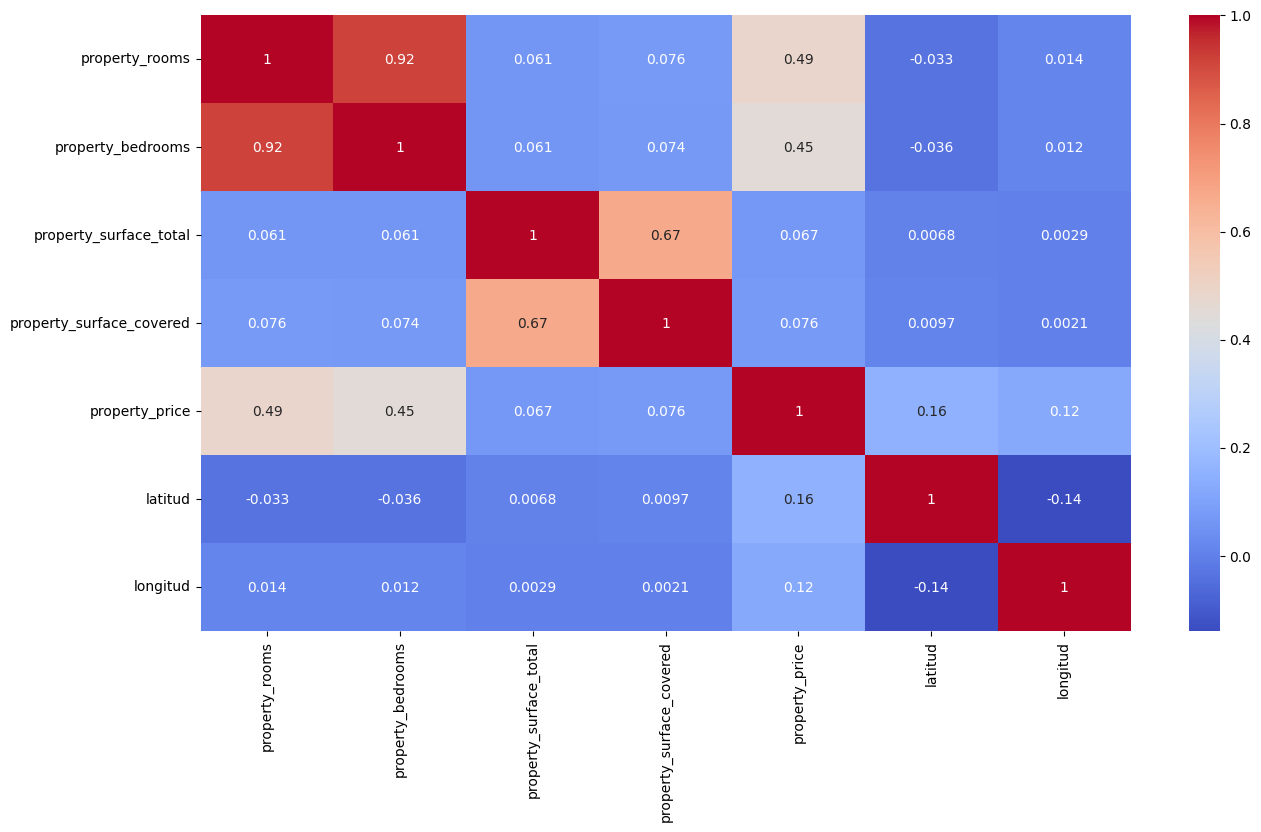

In [77]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')

Como ningua variable tiene correlacion cercana a 0 con la demas, todas son de utilidas. Exceptuando Latidud y Longitud, pero son importante para el dataset

Estructura general del dataset.

In [78]:
df_filtrado.shape

(71424, 12)

In [79]:
df_filtrado.dtypes

start_date                   object
end_date                     object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_title               object
property_price              float64
dtype: object

Se calcula las medidas de la variables cuantitativas Primero la media

In [80]:
media = variables_cuantitativas.mean()
print(media)

property_rooms                   2.823169
property_bedrooms                1.901490
property_surface_total         108.933682
property_surface_covered        84.057072
property_price              222029.119246
latitud                        -34.596365
longitud                       -58.438560
dtype: float64


La mediana

In [81]:
mediana = variables_cuantitativas.median()
print(mediana)

property_rooms                   3.000000
property_bedrooms                2.000000
property_surface_total          65.000000
property_surface_covered        57.000000
property_price              142000.000000
latitud                        -34.595998
longitud                       -58.438796
dtype: float64


La moda

In [82]:
moda = variables_cuantitativas.mode()
print(moda)

   property_rooms  property_bedrooms  property_surface_total  \
0             3.0                1.0                    50.0   

   property_surface_covered  property_price   latitud   longitud  
0                      40.0        110000.0 -34.54125 -58.472966  


Desviacion Estandar

In [83]:
desviacion_estandar = variables_cuantitativas.std()
print(desviacion_estandar)

property_rooms                   1.424810
property_bedrooms                1.072122
property_surface_total        1051.328300
property_surface_covered       682.727892
property_price              301205.009138
latitud                          0.026198
longitud                         0.037946
dtype: float64


Rango

In [84]:
rango = variables_cuantitativas.max() - variables_cuantitativas.min()
print(rango)

property_rooms              3.900000e+01
property_bedrooms           3.300000e+01
property_surface_total      1.369988e+05
property_surface_covered    1.229990e+05
property_price              1.199500e+07
latitud                     1.589355e-01
longitud                    1.871521e-01
dtype: float64


Cuantiles

In [85]:
cuantiles = variables_cuantitativas.quantile([0.25, 0.5, 0.75])
print(cuantiles)

      property_rooms  property_bedrooms  property_surface_total  \
0.25             2.0                1.0                    45.0   
0.50             3.0                2.0                    65.0   
0.75             4.0                3.0                   104.0   

      property_surface_covered  property_price    latitud   longitud  
0.25                      40.0         95000.0 -34.616002 -58.465700  
0.50                      57.0        142000.0 -34.595998 -58.438796  
0.75                      87.0        235000.0 -34.577597 -58.408956  


Se analizar las viriables Cualitativas

In [86]:
for variable in variables_cualitativas:

    cantidad_valores = len(df_filtrado[variable].unique())


    print("Cantidad de valores posibles para", variable, ":", cantidad_valores)

Cantidad de valores posibles para place_l3 : 57
Cantidad de valores posibles para property_type : 3
Cantidad de valores posibles para property_title : 44394


Análisis grafico de las variables mas destacables



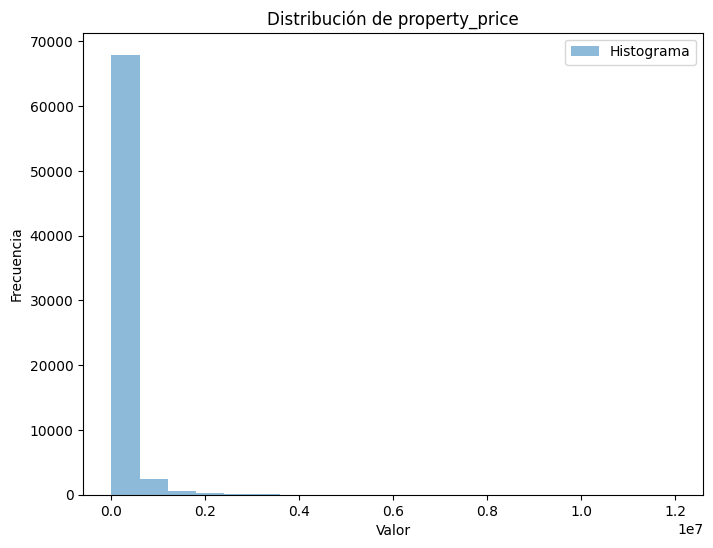

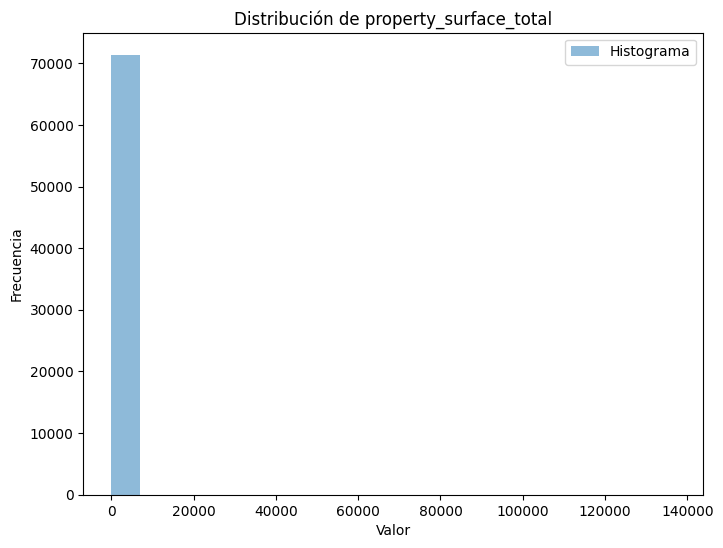

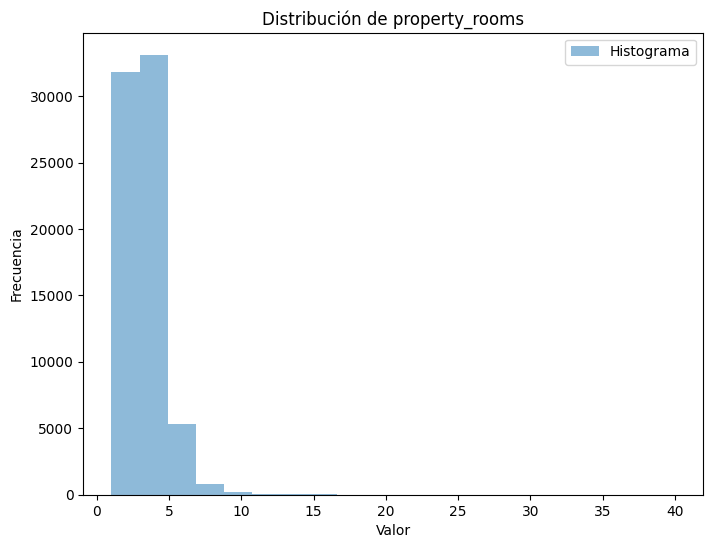

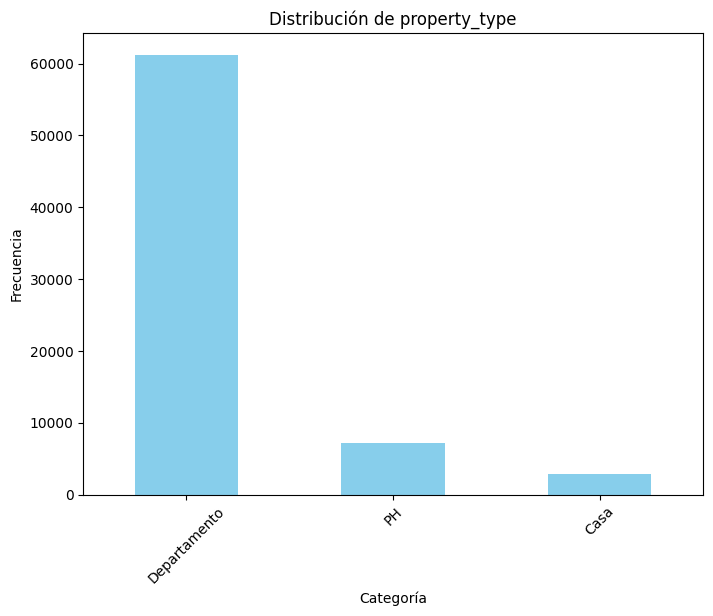

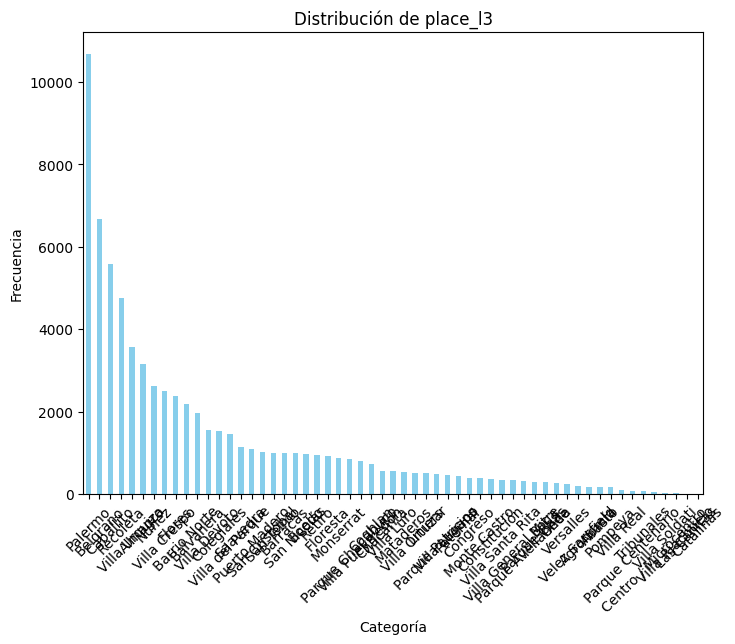

In [87]:
variables_relevantes = ['property_price', 'property_surface_total', 'property_rooms','property_type', 'place_l3']


for variable in variables_relevantes:
    if df_filtrado[variable].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 6))
        plt.hist(df_filtrado[variable], bins=20, alpha=0.5, label='Histograma')
        plt.title(f'Distribución de {variable}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()


for variable in variables_relevantes:
    if df_filtrado[variable].dtype == 'object':
        plt.figure(figsize=(8, 6))
        df_filtrado[variable].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Distribución de {variable}')
        plt.xlabel('Categoría')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.show()

BarPLot de como las viviendas estan distribuidas por la ciudad

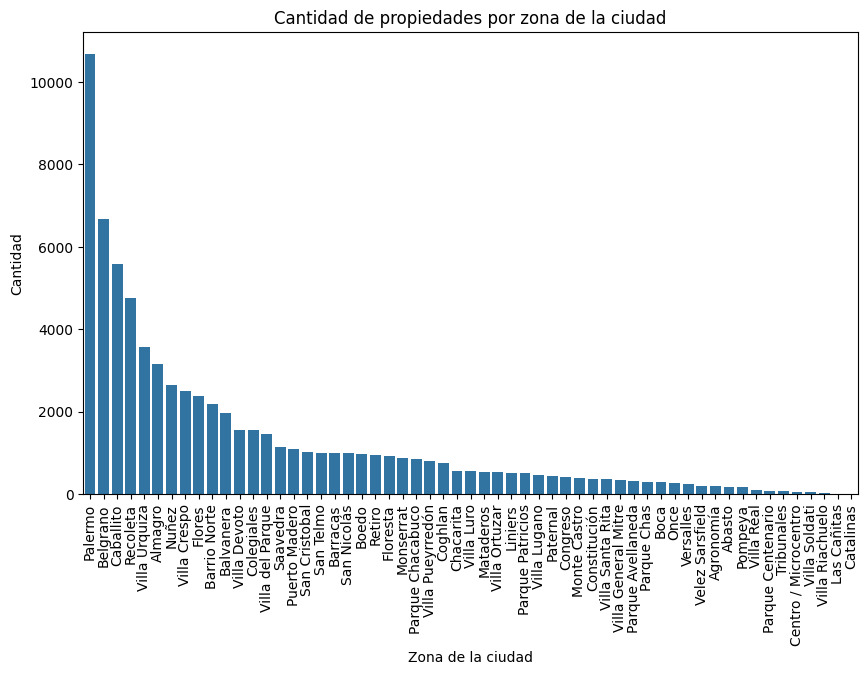

In [88]:
plt.figure(figsize=(10, 6))
sns.countplot(x='place_l3', data=df_filtrado, order=df_filtrado['place_l3'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Zona de la ciudad')
plt.ylabel('Cantidad')
plt.title('Cantidad de propiedades por zona de la ciudad')
plt.show()

Se puede ver que la mayoria de las viviendas se encuentran en Palermo, Belgrano, Caballito y Recoleta

Grafico de torta de la cantidad de departamentos, casas y PH

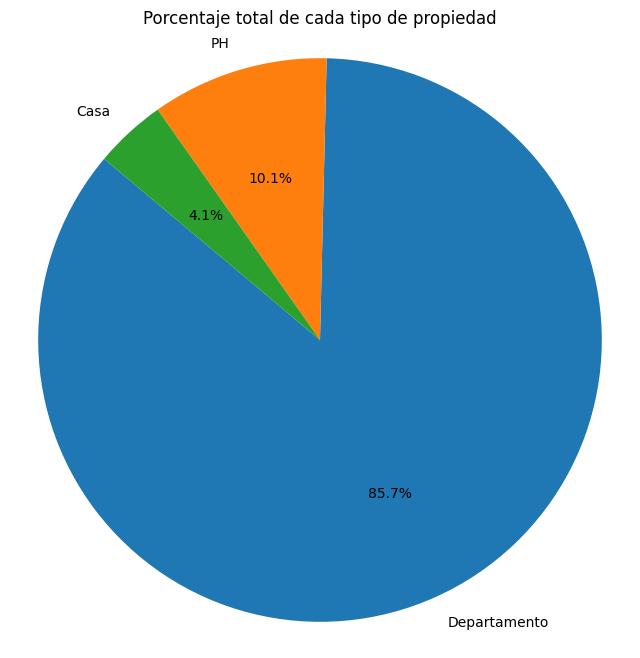

In [89]:
porcentaje_property_type = df_filtrado['property_type'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(porcentaje_property_type, labels=porcentaje_property_type.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Porcentaje total de cada tipo de propiedad')
plt.show()

La gran mayoria de propiedades son departamentos

Analisis de la correlacion entre las variables

Analizó si el precio aumenta dependiendo el tamañano de la vivienda

In [90]:
correlacion_pearson = df_filtrado['property_surface_total'].corr(df_filtrado['property_price'])

print("Correlación de Pearson entre terreno total y precio:", correlacion_pearson)

Correlación de Pearson entre terreno total y precio: 0.06705982483287026


Como el valor es tan cercano a 0, no es linea la relacion del tamaño de la vivienda con su precio

Ahora si la cantidad de habitaciones tiene efecto en el precio de la vivienda

In [91]:
correlacion_pearson = df_filtrado['property_rooms'].corr(df_filtrado['property_price'])

print("Correlación de Pearson entre la cantidad de habitaciones y precio:", correlacion_pearson)

Correlación de Pearson entre la cantidad de habitaciones y precio: 0.4876157234012336


Aca se puede ver una tendencia que entre mas habitaciones, mayor sera el precio de la vivienda, pero en una medida baja, ya que el resultado esta casi justo entre el 0 y el 1. Osea que la correlacion entre estas 2 variables no es extremadamente fuerte.

La correlacion que hay entre el terreno total y la cantidad de habitaicones

In [92]:
correlacion_pearson = df_filtrado['property_surface_total'].corr(df_filtrado['property_rooms'])

print("Correlación de Pearson entre terreno total y la cantidad de habitaciones:", correlacion_pearson)

Correlación de Pearson entre terreno total y la cantidad de habitaciones: 0.061369554953018594


Como el numero esta mas cerca de 0, no hay una correlacion lineal entre el terreno total y la cantidad de habitaciones

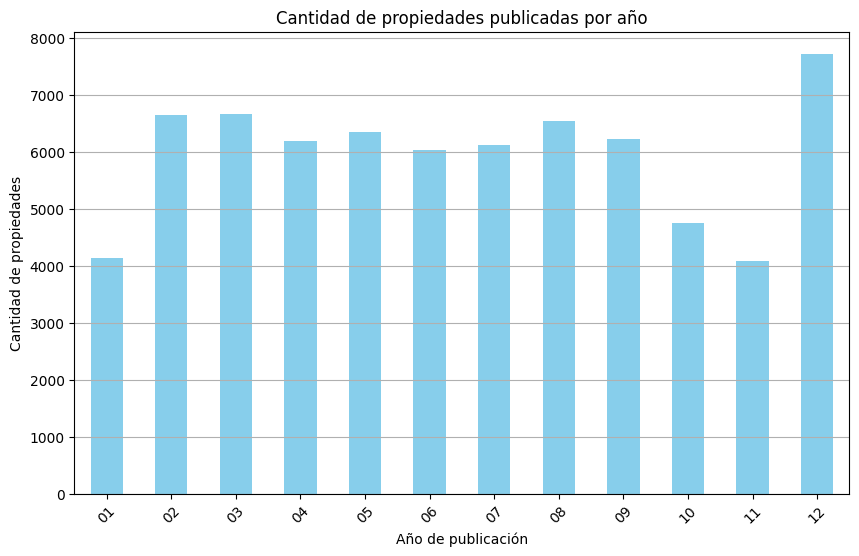

In [93]:
df_filtrado['año_publicacion'] = df_filtrado['start_date'].str.split('-').str[1]

# Contar la cantidad de propiedades publicadas por año
conteo_por_año = df_filtrado['año_publicacion'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades publicadas por año')
plt.xlabel('Año de publicación')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Se puede ver como el mes donde mas se publicaron Propiedades fue el mes de diciembre

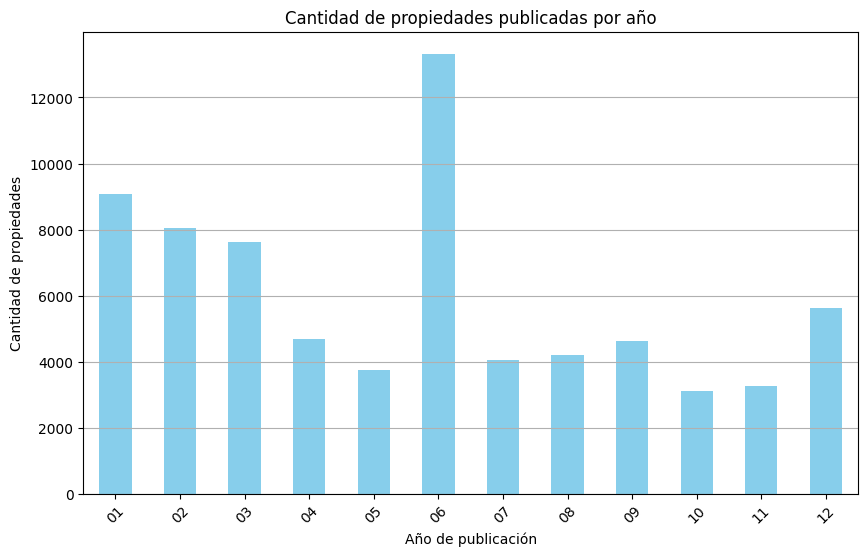

In [94]:
df_filtrado['año_publicacion'] = df_filtrado['end_date'].str.split('-').str[1]

# Contar la cantidad de propiedades publicadas por año
conteo_por_año = df_filtrado['año_publicacion'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades publicadas por año')
plt.xlabel('Año de publicación')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Junio es el mes donde mas propiedades dejaron de estar publicadas para su alquiler

<Figure size 1000x600 with 0 Axes>

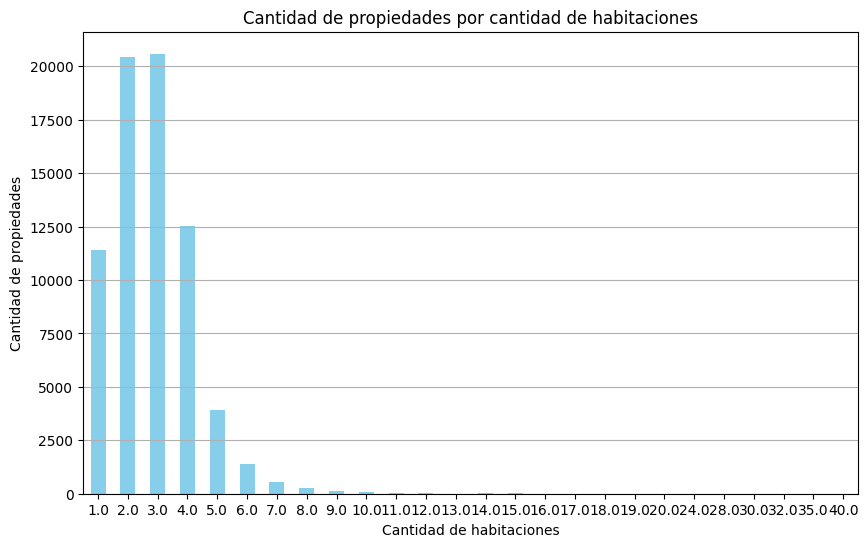

In [95]:
plt.figure(figsize=(10, 6))
conteo_habitaciones = df_filtrado['property_rooms'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_habitaciones.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades por cantidad de habitaciones')
plt.xlabel('Cantidad de habitaciones')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

La mayoria de propiedades oscila entre 2 y 3 habitaciones

<Figure size 1000x600 with 0 Axes>

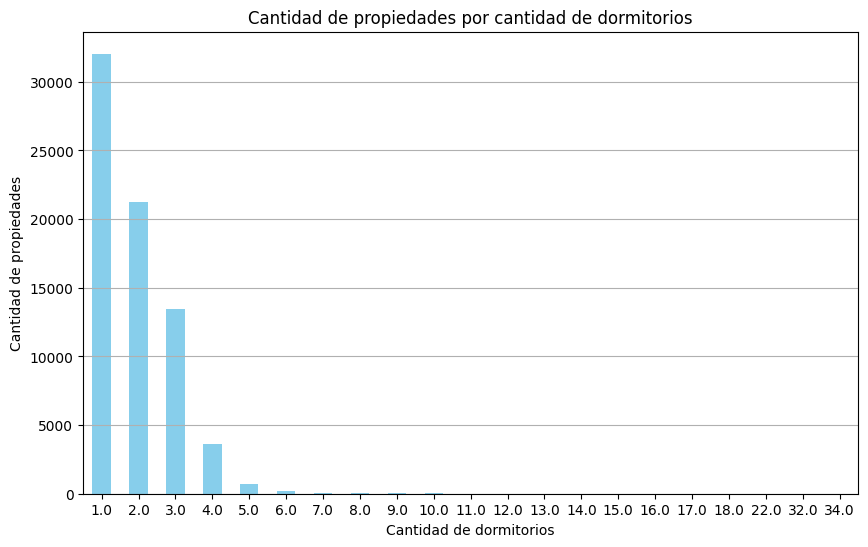

In [96]:
plt.figure(figsize=(10, 6))
conteo_habitaciones = df_filtrado['property_bedrooms'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_habitaciones.plot(kind='bar', color='skyblue')
plt.title('Cantidad de propiedades por cantidad de dormitorios')
plt.xlabel('Cantidad de dormitorios')
plt.ylabel('Cantidad de propiedades')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

La mayoria de departamentos tienen una sola habitacion

Siempre hay mas habitaciones que dormitorios

# Visualizaciones

In [97]:
df_deptos = df_filtrado.copy()

## Precio vs Cantidades de ambientes

*   Dejando de lado los outliers, se puede notar una campana de Gauss que relaciona la cant de ambientes con la propiedad
*   Se notan outliers cuando hay 15 ambientes o más, o cuando el precio de propiedades es mayor a 5 millones



<Axes: xlabel='property_rooms', ylabel='property_price'>

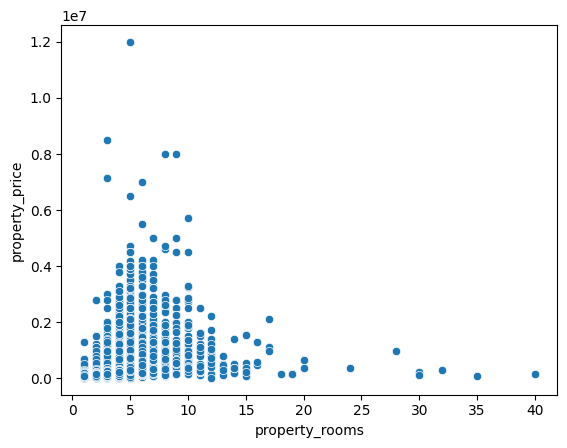

In [98]:
sns.scatterplot(x = df_deptos["property_rooms"], y = df_deptos["property_price"])

## Precio vs Porcentaje de superficie cubierta

El porcentaje de superficie cubierta se calculará de la siguiente forma:
(property_surface_covered/property_surface_total) * 100%

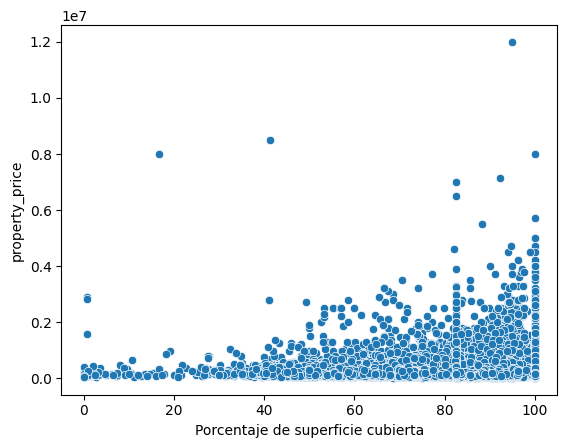

In [99]:
sns.scatterplot(y = df_deptos["property_price"], x = (df_deptos["property_surface_covered"]/df_deptos["property_surface_total"]) * 100)
plt.xlabel("Porcentaje de superficie cubierta")
plt.show()

Podemos ver que el Porcentaje de Superficie Cubierta parece ser un buen indicador para predecir el precio, por lo que lo agregaremos al dataset para ser usado más adelante

In [100]:
df_deptos["property_coverage_percent"] = (df_deptos["property_surface_covered"]/df_deptos["property_surface_total"]) * 100
df_deptos.head(3)

start_date    end_date    latitud   longitud          place_l3  \
0  2021-02-11  2021-03-18 -34.630337 -58.411793  Parque Patricios   
1  2021-12-16  2022-02-09 -34.637319 -58.361124              Boca   
2  2021-11-06  2022-01-27 -34.597205 -58.392474          Recoleta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             2.0                1.0                   139.0   
1  Departamento             3.0                2.0                    58.0   
2  Departamento             3.0                2.0                   133.0   

   property_surface_covered  \
0                      61.0   
1                      55.0   
2                      92.0   

                                      property_title  property_price  \
0  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...        160000.0   
1            VENTA TRES AMBIENTES LA BOCA PISO ALTO          74900.0   
2      Venta de Departamento 3 Ambientes en Recoleta        469200.0   

  año_publicacion  property_coverage_percent  
0              03                  43.884892  
1              02                  94.827586  
2              01                  69.172932

In [101]:
x_test_y_test["property_coverage_percent"] = (x_test_y_test["property_surface_covered"]/x_test_y_test["property_surface_total"]) * 100
x_test_y_test.head(3)

start_date    end_date    latitud   longitud    place_l3 property_type  \
77979  2021-09-07  2022-03-06 -34.572507 -58.447047  Colegiales  Departamento   
4228   2021-10-01  2022-02-09 -34.599391 -58.372185      Retiro  Departamento   
10233  2021-09-22  2022-03-09 -34.576547 -58.431213     Palermo  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
77979             3.0                2.0                    65.0   
4228              3.0                2.0                    51.0   
10233             4.0                3.0                    89.0   

       property_surface_covered  \
77979                      56.0   
4228                       51.0   
10233                      81.0   

                                          property_title  property_price  \
77979  3 ambientes con vista totalmente abierta . Ent...        248000.0   
4228           Depto venta 3 amb 51m2 Retiro OPORTUNIDAD         85000.0   
10233  Excelente departamento 4 ambientes, piso alto,...        240000.0   

       property_coverage_percent  
77979                  86.153846  
4228                  100.000000  
10233                  91.011236

## Precios vs Barrio

En este sección comparamos distintas maneras de medir el precio de la propiedad y las compararemos contra los Barrios. Esto tiene dos objetivos:
*   Comparar los precios de los barrios, ya que creemos que el barrio donde se ubica una propiedad afecta considerablemente al precio
*   Ver cual/es método/s de valoración (Precio total, Precio por metro cuadrado, Precio por ambiente) son los más adecuados para poder conocer lo anterior

Viendo los gráficos, se puede concluir que:
*   En general Puerto Madero, Recoleta, Belgrano, Palermo, y Las Cañitas parecen contener las propeidades más caras
*   Precio por metro cuadrado parece ser un método poco adecuado para valorar los barrios, debido a su alta varianza
*   Precio total y Precio por ambiente tienen mucha menos varianza que Precio por metro cuadrado, lo cual las convierte en buenos indicadores del valor promedio de los barrios





### Precio de la propiedad vs Barrio

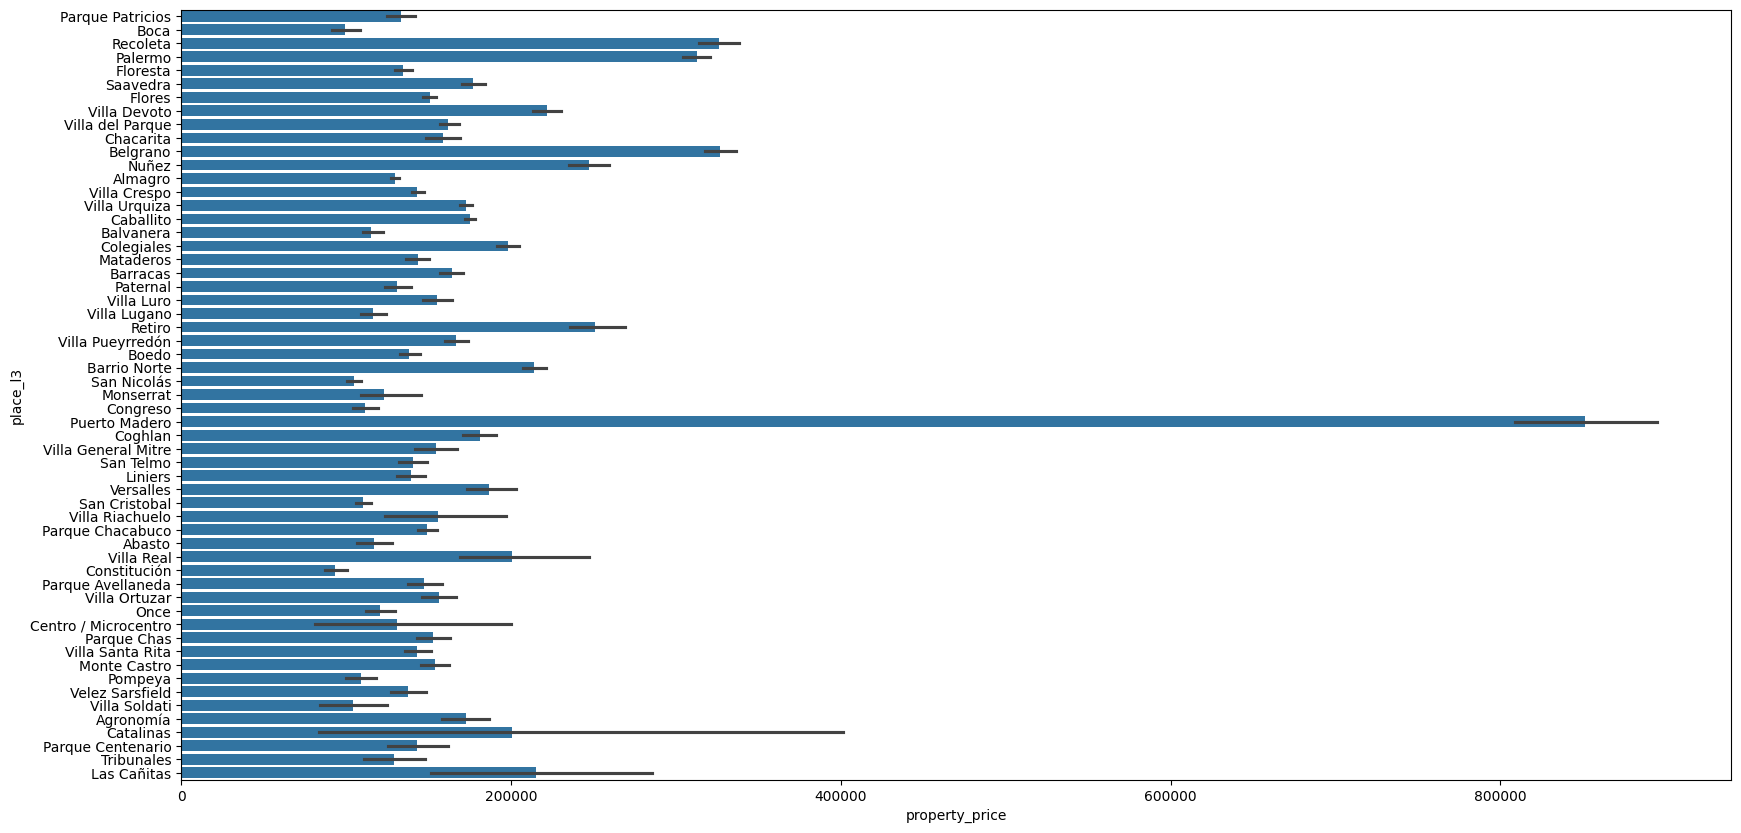

In [102]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = df_deptos["property_price"])
visu_precios_por_barrio.figure.set_size_inches(20, 10)

### Precio por metro cuadrado vs Barrio

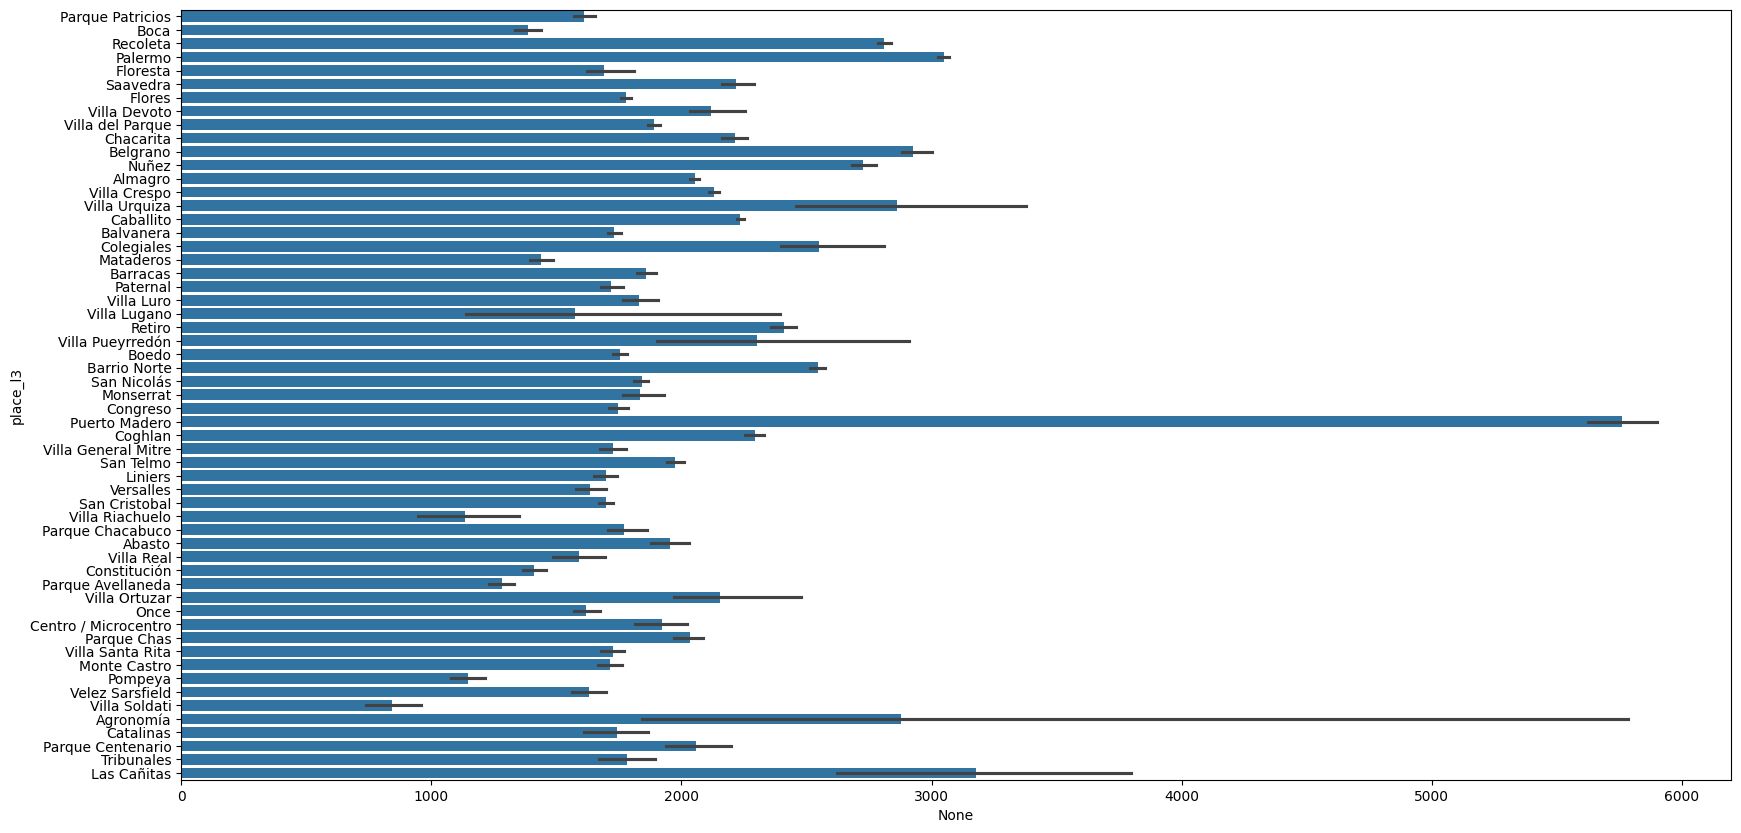

In [103]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = (df_deptos["property_price"]/df_deptos["property_surface_total"]))
visu_precios_por_barrio.figure.set_size_inches(20, 10)

### Precio por ambiente vs Barrio

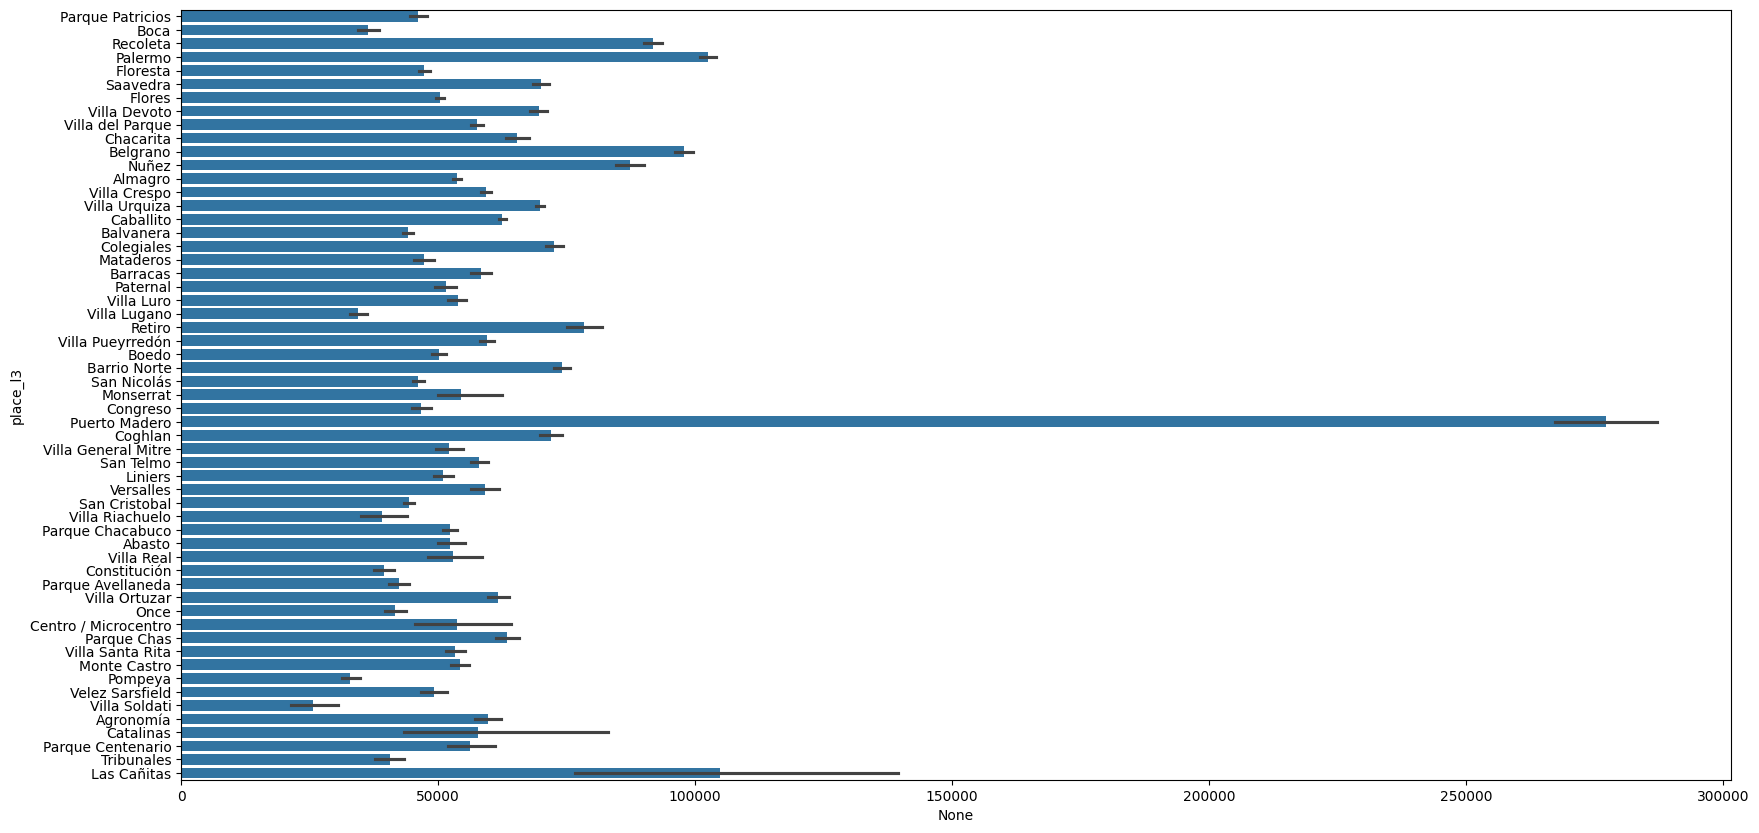

In [104]:
visu_precios_por_barrio = sns.barplot(y = df_deptos["place_l3"], x = (df_deptos["property_price"]/df_deptos["property_rooms"]))
visu_precios_por_barrio.figure.set_size_inches(20, 10)

## Precio por tipo de propiedad

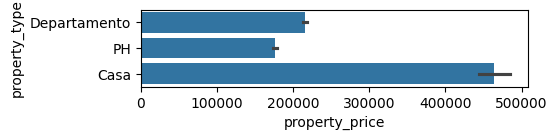

In [105]:
visu_precios_por_tipo = sns.barplot(y = df_deptos["property_type"], x = df_deptos["property_price"])
visu_precios_por_tipo.figure.set_size_inches(5, 1)

# Outliers

En esta sección se examinarán los outliers del dataset

## *Definición de función para LOF*

In [106]:
from sklearn.neighbors import LocalOutlierFactor

# df = dataframe, nombre_col_x = string, nombre_col_y = string, cant_vecinos = int
# Genera un gráfico scatterplot entre nombre_col_x y nombre_col_y donde están expresados los LOF, teniendo en cuenta la cantidad de vecinos proporcionada
# Devuelve un DF que es una copia del DF dado pero solo con nombre_col_x, nombre_col_y, y los LOF scores correspondientes
def graficar_lof(df,nombre_col_x,nombre_col_y,cant_vecinos):
  df_lof = df[[nombre_col_x,nombre_col_y]]

  # Normalizo los valores de X e Y usando Min-Max, para que medir sus distancias sea más certero
  min_x = df_lof[nombre_col_x].min()
  max_x = df_lof[nombre_col_x].max()
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
  min_y = df_lof[nombre_col_y].min()
  max_y = df_lof[nombre_col_y].max()
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)

  # Conjunto de entrenamiento
  X = df_lof[[nombre_col_x, nombre_col_y]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=cant_vecinos)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df_lof["scores"] = clf.negative_outlier_factor_

  # Calculo radio para plotear score
  radius = (df_lof["scores"].max() - df_lof["scores"]) / (df_lof["scores"].max() - df_lof["scores"].min())

  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)")
  plt.scatter(
      df_lof[nombre_col_x].values,
      df_lof[nombre_col_y].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df_lof[nombre_col_x].values,
      df_lof[nombre_col_y].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return df_lof

## Ambientes

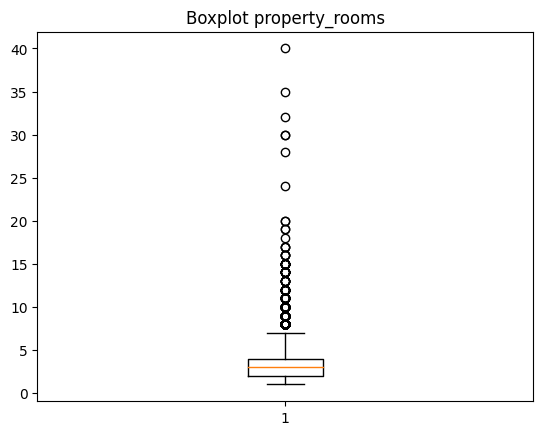

In [107]:
plt.boxplot(df_deptos["property_rooms"])
plt.title("Boxplot property_rooms")
plt.show()

Veamos los outliers moderados (+/- 1,5 * Rango intercuartil)

In [108]:
# Cuartiles
Q1_altura = np.quantile(df_deptos.property_rooms, 0.25)
Q3_altura = np.quantile(df_deptos.property_rooms, 0.75)

# Rango intercuartil
IQR_altura = Q3_altura - Q1_altura

# Limite inferior Outliers
out_inf = Q1_altura - 1.5 * IQR_altura

# Limite superior Outliers
out_sup = Q1_altura + 1.5 * IQR_altura

out_inf, out_sup

(-1.0, 5.0)

In [109]:
# Outliers moderados
df_deptos[(df_deptos["property_rooms"] <= out_inf) | (df_deptos["property_rooms"] >= out_sup)].shape

(6460, 14)

Ya que los moderados son muchos (Las propiedades de 5 o más ambientes son comunes) veamos los extremos (+/- 3 * Rango intercuartil)

In [110]:
# Limite inferior Outliers
out_inf_ex = Q1_altura - 3 * IQR_altura

# Limite superior Outliers
out_sup_ex = Q1_altura + 3 * IQR_altura

out_inf_ex, out_sup_ex

(-4.0, 8.0)

In [111]:
# Outliers extremos
df_deptos[(df_deptos["property_rooms"] <= out_inf_ex) | (df_deptos["property_rooms"] >= out_sup_ex)].shape

(568, 14)

Como se puede ver, los outliers extremos son mucho menos frecuentes, pero aún así una vivienda con 8 ambientes es razonable. Sin embargo, el boxplot sugiere que las viviendas de aproximadamente 10 ambientes o más son escasas. Echemos un vistazo:

In [112]:
df_deptos[(df_deptos["property_rooms"] <= out_inf_ex) | (df_deptos["property_rooms"] >= out_sup_ex)]["property_rooms"].value_counts()

property_rooms
8.0     260
9.0     114
10.0     83
11.0     35
12.0     25
15.0     13
14.0     12
13.0      7
16.0      4
17.0      3
19.0      2
30.0      2
20.0      2
40.0      1
24.0      1
32.0      1
35.0      1
18.0      1
28.0      1
Name: count, dtype: int64

In [113]:
df_deptos[df_deptos["property_rooms"] >= 11]

start_date    end_date    latitud   longitud          place_l3  \
90     2021-09-23  2022-03-09 -34.609264 -58.377884         Monserrat   
852    2021-12-16  2022-03-25 -34.581483 -58.434970           Palermo   
870    2021-09-25  2021-09-26 -34.600688 -58.514393      Villa Devoto   
872    2021-05-15  2021-05-18 -34.580976 -58.495637  Villa Pueyrredón   
970    2021-07-02  2021-07-28 -34.658535 -58.481791         Mataderos   
...           ...         ...        ...        ...               ...   
68639  2021-04-21  2021-05-26 -34.594375 -58.380131            Retiro   
68758  2021-07-26  9999-12-31 -34.612036 -58.415431           Almagro   
69303  2021-03-23  2021-06-05 -34.627279 -58.373637          Barracas   
69367  2021-09-24  2022-03-09 -34.612216 -58.384667         Monserrat   
70912  2021-12-09  2022-01-27 -34.632730 -58.434728  Parque Chacabuco   

      property_type  property_rooms  property_bedrooms  \
90     Departamento            11.0               10.0   
852              PH            12.0                9.0   
870            Casa            15.0               10.0   
872            Casa            11.0               11.0   
970            Casa            12.0               10.0   
...             ...             ...                ...   
68639  Departamento            11.0                8.0   
68758            PH            11.0                9.0   
69303          Casa            15.0               14.0   
69367  Departamento            15.0               14.0   
70912          Casa            12.0                6.0   

       property_surface_total  property_surface_covered  \
90                      295.0                     295.0   
852                     558.0                     418.0   
870                     428.0                     348.0   
872                     341.0                     341.0   
970                     400.0                     370.0   
...                       ...                       ...   
68639                   676.0                     493.0   
68758                   370.0                     280.0   
69303                  2500.0                    2500.0   
69367                   268.0                     268.0   
70912                   654.0                     520.0   

                                          property_title  property_price  \
90     Venta departamento de 10 ambientes en Monserra...        380000.0   
852    PH venta Palermo Hollywood jardín apto profesi...        850000.0   
870            Venta casa geriátrico en lote 8,66x29,45         390000.0   
872     Casa, cochera, terrazas, patio, Villa Pueyrredón        360000.0   
970                                     Casa - Mataderos        130000.0   
...                                                  ...             ...   
68639  Excelente duplex en edificio francés de gran c...       1100000.0   
68758                                       PH - Almagro        425000.0   
69303         Casa de 2500 m2, ideal para uso comercial.       1550000.0   
69367  Piso en Venta en Monserrat - Ideal Hostel - A ...        200000.0   
70912  Casa 12 ambientes en venta en Parque Chacabuco...        730000.0   

      año_publicacion  property_coverage_percent  
90                 03                 100.000000  
852                03                  74.910394  
870                09                  81.308411  
872                05                 100.000000  
970                07                  92.500000  
...               ...                        ...  
68639              05                  72.928994  
68758              12                  75.675676  
69303              06                 100.000000  
69367              03                 100.000000  
70912              01                  79.510703  

[111 rows x 14 columns]

Efectivamente. Además, entre los domicilios se pueden ver hoteles y datos mal ingresados (por ejemplo, un departamento en Palermo que dice tener 4 ambientes, pero tiene 40 como valor en property_rooms). Por la baja fiabilidad de este subconjunto, además de su reducido tamaño, decidimos eliminarlo

In [114]:
df_deptos = df_deptos[df_deptos["property_rooms"] < 11]
df_deptos.shape

(71313, 14)

## Ambientes vs Dormitorios

Después de eliminar los outliers de ambientes, se puede ver que los outliers de Dormitorios también han desaparecido (Ya que los dos tienen correlación alta). Además, eliminar outliers en este caso no sería conveniente ya que:
*   En la vida real, diversas propiedades pueden tener diversas cantidades de
dormitorios en relación a ambientes
*   Los casos donde Ambientes==Dormitorios pueden deberse al hecho de que cualquiera de los ambientes pueden usarse como dormitorios si el comprador de la propiedad lo desea

<Axes: xlabel='property_rooms', ylabel='property_bedrooms'>

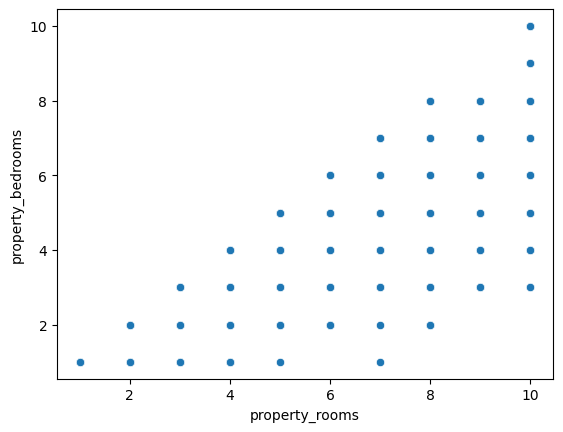

In [115]:
sns.scatterplot(x = df_deptos["property_rooms"], y = df_deptos["property_bedrooms"])

## Precio vs Porcentaje de superficie cubierta

Volvemos a la visualización que hicimos antes, y analizamos sus outliers

In [116]:
df_deptos["property_coverage_percent"] = (df_deptos["property_surface_covered"]/df_deptos["property_surface_total"]) * 100

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

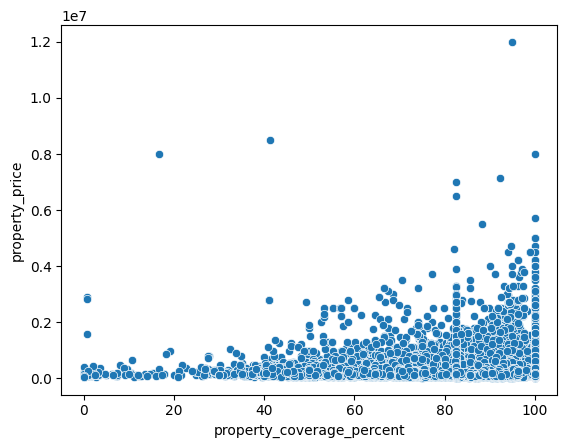

In [117]:
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

Primero veamos los outliers más obvios, comenzando por las propiedades con precio mayor a 6 millones

In [118]:
df_deptos[df_deptos["property_price"]>=6000000]

start_date    end_date    latitud   longitud       place_l3  \
7678   2021-01-16  2021-10-09 -34.614977 -58.362648  Puerto Madero   
11925  2021-09-13  2021-09-16 -34.596801 -58.383768       Recoleta   
12393  2021-09-14  2022-06-05 -34.552226 -58.439016       Belgrano   
33154  2021-05-12  2021-05-14 -34.565947 -58.442326       Belgrano   
42652  2021-03-26  2021-06-05 -34.572494 -58.462433       Belgrano   
52490  2021-03-04  2021-06-05 -34.616918 -58.359927  Puerto Madero   
66285  2021-02-17  2021-02-19 -34.608300 -58.371200      Monserrat   

      property_type  property_rooms  property_bedrooms  \
7678   Departamento             5.0                3.0   
11925  Departamento             8.0                2.0   
12393  Departamento             6.0                4.0   
33154          Casa             9.0                5.0   
42652          Casa             5.0                4.0   
52490  Departamento             3.0                2.0   
66285          Casa             3.0                2.0   

       property_surface_total  property_surface_covered  \
7678               739.189765                     610.0   
11925              900.000000                     150.0   
12393              605.893250                     500.0   
33154             1763.000000                    1763.0   
42652             3367.000000                    3197.0   
52490              128.000000                     118.0   
66285              225.000000                      93.0   

                                          property_title  property_price  \
7678                       Departamento en Puerto Madero       6500000.0   
11925                            Departamento - Recoleta       8000000.0   
12393                            Departamento - Belgrano       7000000.0   
33154  Casa  Estilo Frances en Venta y/o Alquiler | V...       8000000.0   
42652                                  Casa - Belgrano R      12000000.0   
52490                       Departamento - Puerto Madero       7149999.0   
66285  Oportunidad al Costo! Venta Preciosa Casa a Es...       8500000.0   

      año_publicacion  property_coverage_percent  
7678               10                  82.522788  
11925              09                  16.666667  
12393              06                  82.522788  
33154              05                 100.000000  
42652              06                  94.950995  
52490              06                  92.187500  
66285              02                  41.333333

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

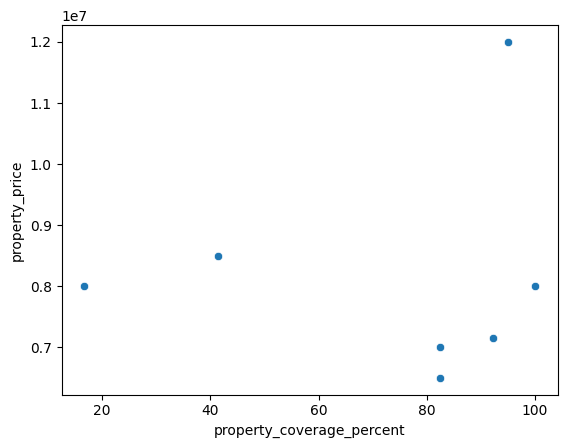

In [119]:
sns.scatterplot(y = df_deptos[df_deptos["property_price"]>=6000000]["property_price"], x = df_deptos["property_coverage_percent"])

Si bien podemos ver algunos barrios caros como Puerto Madero y Belgrano, los eliminamos ya que son un número muy pequeño de outliers

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

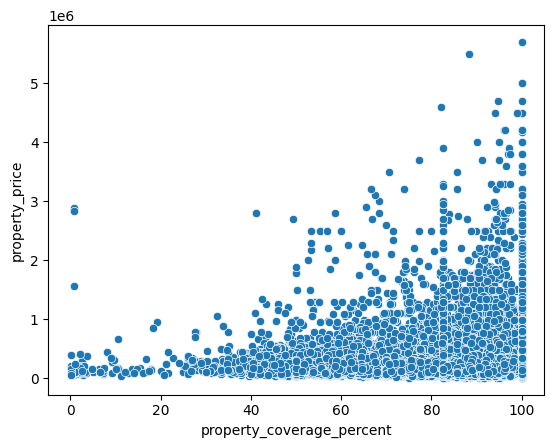

In [120]:
df_deptos = df_deptos[df_deptos["property_price"] < 6000000]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

Ahora veamos los outliers de la izquierda, donde el precio es mayor a 1 millón pero el porcentaje de cobertura es muy bajo

In [121]:
df_deptos[(df_deptos["property_price"] > 1000000) & (df_deptos["property_coverage_percent"] < 10)]

start_date    end_date    latitud   longitud place_l3 property_type  \
14519  2021-04-24  2021-06-05 -34.571747 -58.422612  Palermo  Departamento   
44931  2021-04-24  2021-06-05 -34.571747 -58.422612  Palermo  Departamento   
56440  2021-04-24  2021-06-05 -34.571747 -58.422612  Palermo  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
14519             5.0                4.0                 42110.0   
44931             4.0                3.0                 42110.0   
56440             5.0                4.0                 42110.0   

       property_surface_covered  \
14519                     307.0   
44931                     307.0   
56440                     307.0   

                                          property_title  property_price  \
14519  Reventa - Departamento - Palermo Nuevo - Liber...       2890500.0   
44931  Reventa - Departamento - Palermo Nuevo - Liber...       1568760.0   
56440  Reventa - Departamento - Palermo Nuevo - Liber...       2829000.0   

      año_publicacion  property_coverage_percent  
14519              06                   0.729043  
44931              06                   0.729043  
56440              06                   0.729043

Si bien son de Palermo, un barrio caro, es muy extraño que un departamento tenga tan poca superficie cubierta y sea tan caro, por lo que los eliminaremos

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

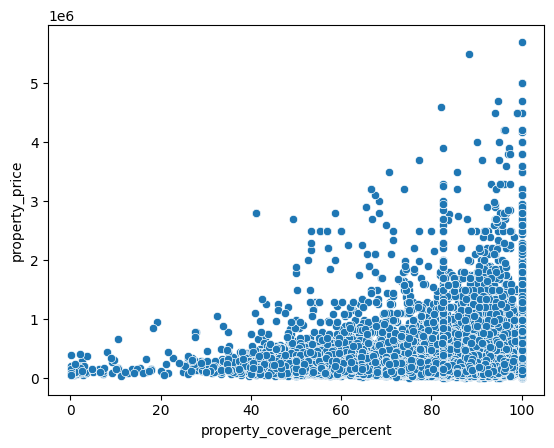

In [122]:
df_deptos = df_deptos[~((df_deptos["property_price"] > 1000000) & (df_deptos["property_coverage_percent"] < 10))]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

El resto de outliers los veremos con LOF

<ipython-input-106-19cc9415282a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
<ipython-input-106-19cc9415282a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)
<ipython-input-106-19cc9415282a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

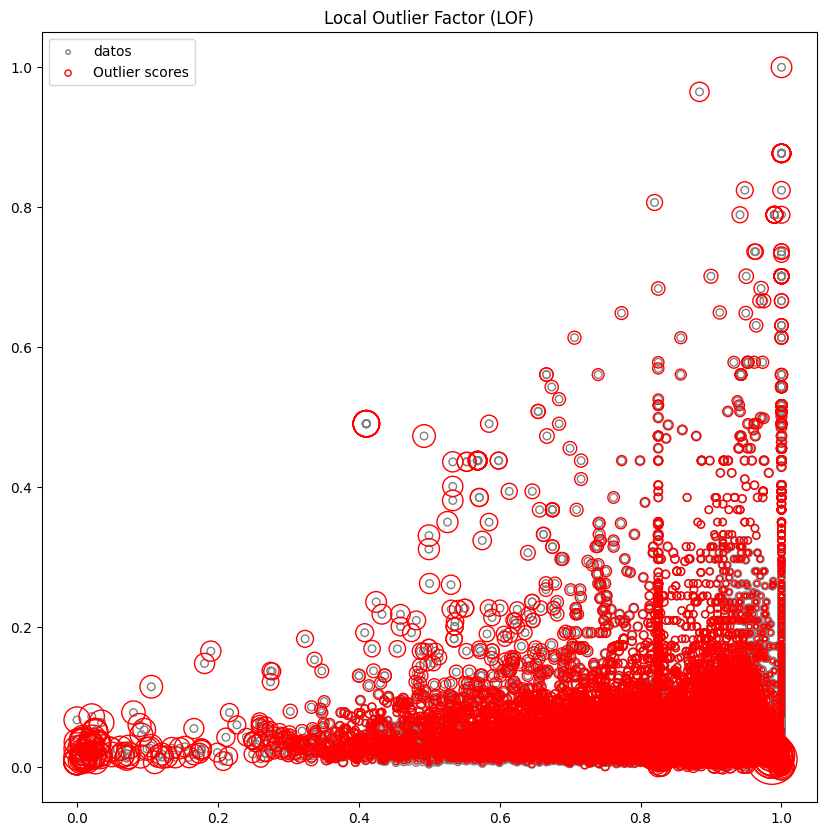

In [123]:
df_lof = graficar_lof(df_deptos,"property_coverage_percent","property_price",600)

Probando varios umbrales de LOF concluimos que -1.7 es el indicado para encontrar un equilibrio entre eliminar los outliers más severos y no eliminar demasiadas entradas, lo cual se puede ver en el siguiente gráfico

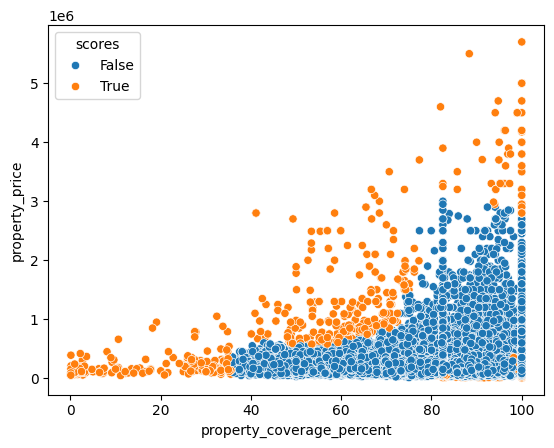

Hay un total de 1518 outliers


In [124]:
es_outlier = df_lof["scores"] <= -1.7
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"], hue=es_outlier)
plt.show()
print("Hay un total de", df_lof[es_outlier].shape[0], "outliers")

Podemos ver que entre los outliers hay más casas y PHs que en los inliers, sin embargo la diferencia no es sustancial

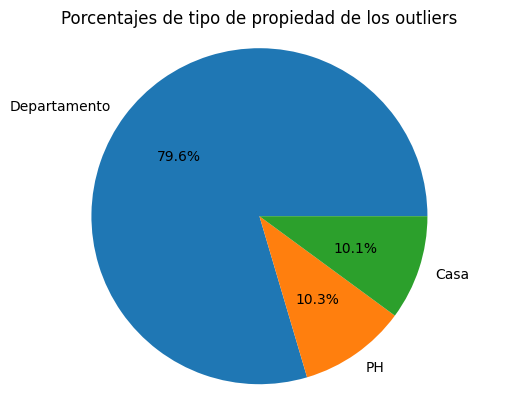

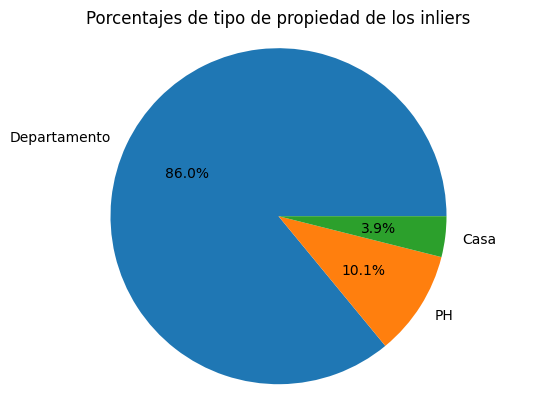

In [125]:
outliers_property_type = df_deptos[es_outlier]['property_type'].value_counts() * 100

plt.pie(outliers_property_type, labels=outliers_property_type.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Porcentajes de tipo de propiedad de los outliers')
plt.show()

no_outliers_property_type = df_deptos[~es_outlier]['property_type'].value_counts() * 100

plt.pie(no_outliers_property_type, labels=no_outliers_property_type.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Porcentajes de tipo de propiedad de los inliers')
plt.show()

Debido a la reducida cantidad de outliers con respecto al resto del conjunto, además de que los mismos no varían mucho del resto del conjunto, procedemos a eliminarlos

<Axes: xlabel='property_coverage_percent', ylabel='property_price'>

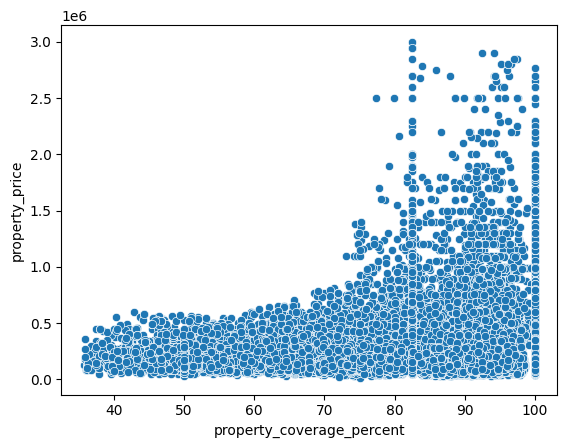

In [126]:
df_deptos = df_deptos[~es_outlier]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_coverage_percent"])

## Superficie total

### Método Boxplot

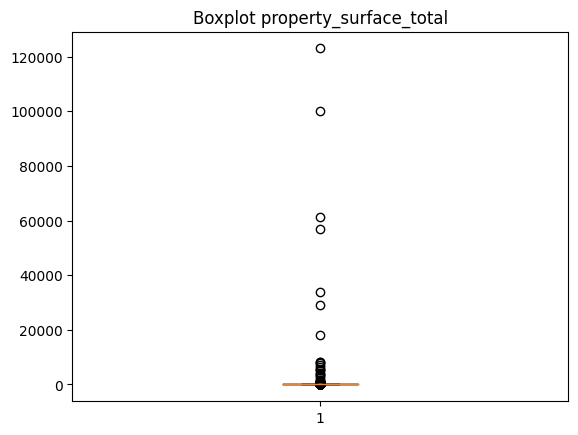

In [127]:
plt.boxplot(df_deptos["property_surface_total"])
plt.title("Boxplot property_surface_total")
plt.show()

Veremos sus outliers moderados y extremos

In [128]:
# Cuartiles
Q1_altura = np.quantile(df_deptos["property_surface_total"], 0.25)
Q3_altura = np.quantile(df_deptos["property_surface_total"], 0.75)

# Rango intercuartil
IQR_altura = Q3_altura - Q1_altura

# Limite inferior Outliers
out_inf = Q1_altura - 1.5 * IQR_altura

# Limite superior Outliers
out_sup = Q1_altura + 1.5 * IQR_altura

# Outliers moderados
df_deptos[(df_deptos["property_surface_total"] <= out_inf) | (df_deptos["property_surface_total"] >= out_sup)].shape[0]

11577

In [129]:
# Limite inferior Outliers
out_inf_ex = Q1_altura - 3 * IQR_altura

# Limite superior Outliers
out_sup_ex = Q1_altura + 3 * IQR_altura

# Outliers extremos
df_deptos[(df_deptos["property_surface_total"] <= out_inf_ex) | (df_deptos["property_surface_total"] >= out_sup_ex)].shape[0]

4006

Son demasiados outliers, por lo que recurriremos a otro método

### Método Z-score

Usamos metodo Z-score modificado, ya que el método Boxplot nos dá demasiados outliers. Además, eligiremos un umbral de |Z|>12 por esa misma razón.

In [130]:
def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

df_deptos_zscore = df_deptos.copy()

df_deptos_zscore["zm_property_surface_total"] =  z_mod_calculation(df_deptos_zscore["property_surface_total"])

outliers_zscore = (df_deptos_zscore["zm_property_surface_total"] > 12) | (df_deptos_zscore["zm_property_surface_total"] < -12)

df_deptos_zscore[outliers_zscore].shape[0]

236

La propiedad con menor superficie entre los outliers tiene la siguiente superficie

In [131]:
df_deptos_zscore[outliers_zscore]["property_surface_total"].min()

494.0

Las propiedades que no fueron detectadas como outliers tienen la siguiente distribución

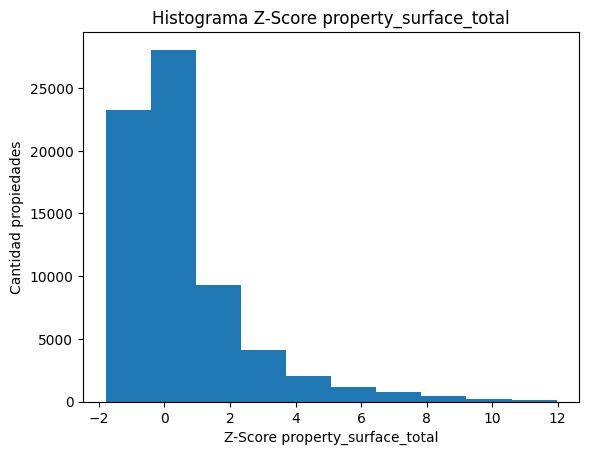

In [132]:
plt.hist(df_deptos_zscore[~outliers_zscore]["zm_property_surface_total"])
plt.title("Histograma Z-Score property_surface_total")
plt.xlabel("Z-Score property_surface_total")
plt.ylabel("Cantidad propiedades")
plt.show()

Procedemos a eliminar los outliers ya que son escasos, además que las propiedades con demasiada superficie podrían afectar la predicción del precio

In [133]:
df_deptos = df_deptos[~outliers_zscore]
df_deptos.shape

(69549, 14)

## Superficie Total vs Cubierta

Si bien parecen haber outliers en esta relación, decidimos no tratarlos ya que diversas propiedades pueden tener diversos porcentajes de superficie cubierta debido a decisiones arquitectónicas distintas para cada propiedad


<Axes: xlabel='property_surface_total', ylabel='property_surface_covered'>

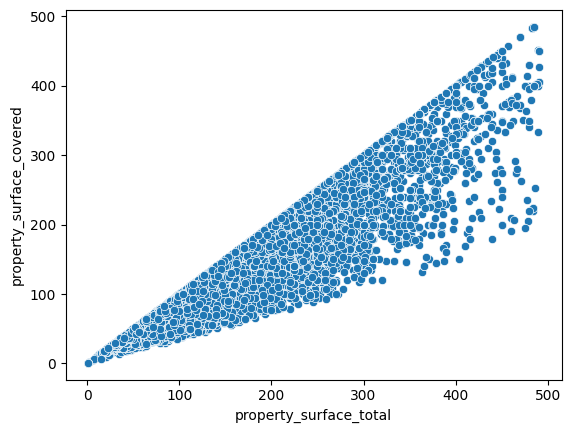

In [134]:
sns.scatterplot(x = df_deptos["property_surface_total"], y = df_deptos["property_surface_covered"])

## Precio vs Superficie total *(Obligatorio)*

Como pide el ejercicio, veremos si quedan outliers analizando Precio vs Superficie total

<Axes: xlabel='property_surface_total', ylabel='property_price'>

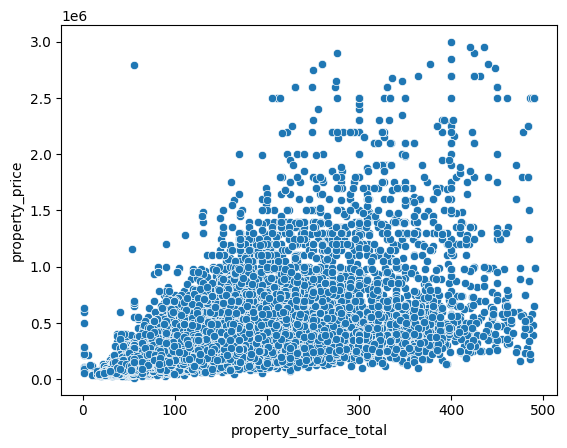

In [135]:
sns.scatterplot(x = df_deptos["property_surface_total"], y = df_deptos["property_price"])

Calculamos outliers con LOF

<ipython-input-106-19cc9415282a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_x] = (df_lof[nombre_col_x] - min_x) / (max_x - min_x)
<ipython-input-106-19cc9415282a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lof[nombre_col_y] = (df_lof[nombre_col_y] - min_y) / (max_y - min_y)
<ipython-input-106-19cc9415282a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

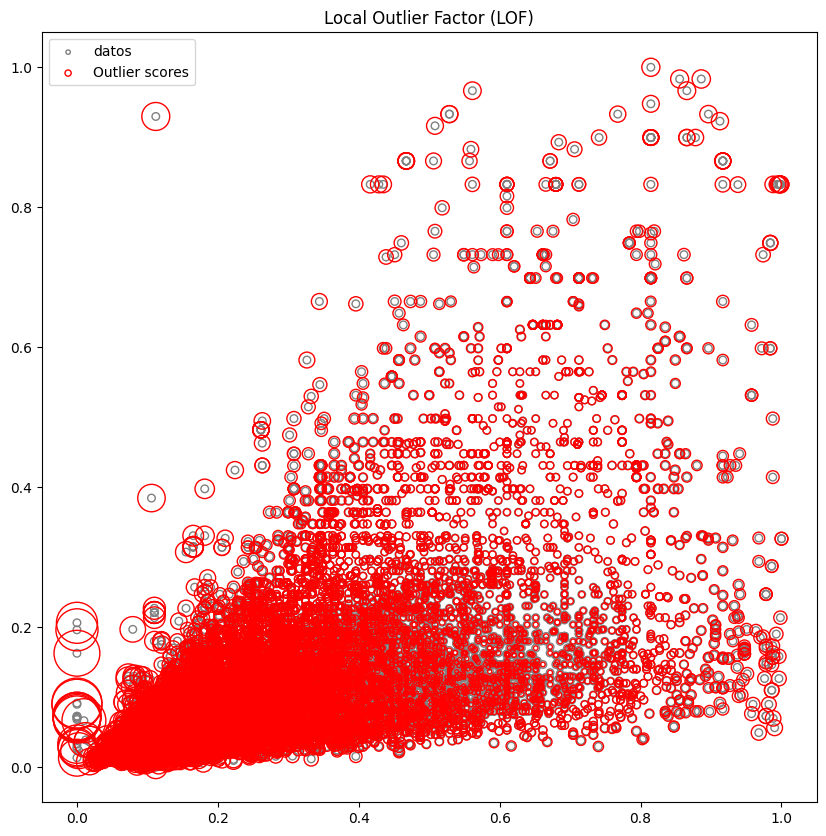

In [136]:
df_lof_pr_sup = graficar_lof(df_deptos,"property_surface_total","property_price",600)

Probando varios umbrales de LOF concluimos que -1.4 es el indicado para encontrar un equilibrio entre eliminar los outliers más severos y no eliminar demasiadas entradas, lo cual se puede ver en el siguiente gráfico.

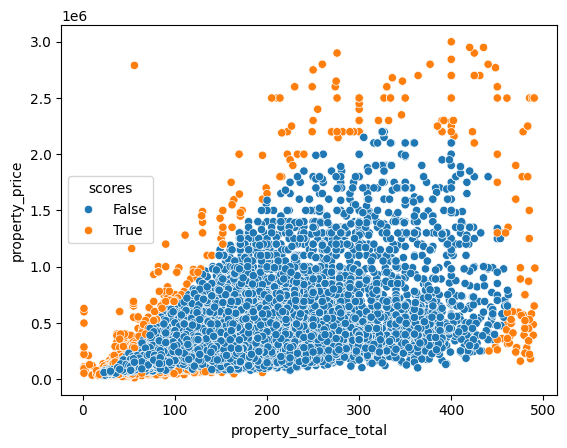

Hay un total de 1512 outliers


In [137]:
es_outlier = df_lof_pr_sup["scores"] <= -1.4
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_surface_total"], hue=es_outlier)
plt.show()
print("Hay un total de", df_deptos[es_outlier].shape[0], "outliers")

Además, esto tiene el efecto de eliminar las propiedades que tienen valores absurdos de Precio por Metro Cuadrado, lo cual será útil en la etapa de clasificación.
Procedemos a eliminarlos.

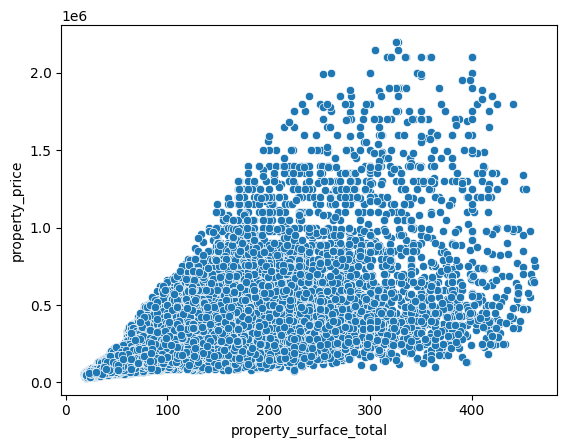

In [138]:
df_deptos = df_deptos[~es_outlier]
sns.scatterplot(y = df_deptos["property_price"], x = df_deptos["property_surface_total"])
plt.show()

In [139]:
#df_deptos.to_csv("/tmp/properati_argentina_2021_train_XY_preprocesado_y_outlier.csv", index=False)

In [140]:
train_preprocesado_y_outlier_XY_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021_train_XY_preprocesado_y_outlier.csv'
df_train_preprocesado_y_outlier = pd.read_csv(train_preprocesado_y_outlier_XY_url)

In [141]:
df_train_preprocesado_y_outlier.head(5)







start_date    end_date    latitud   longitud          place_l3  \
0  2021-02-11  2021-03-18 -34.630337 -58.411793  Parque Patricios   
1  2021-12-16  2022-02-09 -34.637319 -58.361124              Boca   
2  2021-11-06  2022-01-27 -34.597205 -58.392474          Recoleta   
3  2021-03-30  2021-04-04 -34.590503 -58.408862           Palermo   
4  2021-02-12  2021-04-20 -34.576259 -58.424250           Palermo   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             2.0                1.0              139.000000   
1  Departamento             3.0                2.0               58.000000   
2  Departamento             3.0                2.0              133.000000   
3  Departamento             4.0                3.0               81.189696   
4  Departamento             1.0                1.0               65.436471   

   property_surface_covered  \
0                      61.0   
1                      55.0   
2                      92.0   
3                      67.0   
4                      54.0   

                                      property_title  property_price  \
0  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...        160000.0   
1            VENTA TRES AMBIENTES LA BOCA PISO ALTO          74900.0   
2      Venta de Departamento 3 Ambientes en Recoleta        469200.0   
3                             Departamento - Palermo        212000.0   
4  Amplio y luminoso monoambiente con terraza en ...        140000.0   

   año_publicacion  property_coverage_percent  
0                3                  43.884892  
1                2                  94.827586  
2                1                  69.172932  
3                4                  82.522788  
4                4                  82.522788

# Preproceso para agrupación



In [142]:
zona_kmeans_df = pd.read_csv(train_preprocesado_y_outlier_XY_url)
zona_save_col_df = zona_kmeans_df.copy()

In [143]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
property_type_ohe = ohe.fit_transform(zona_kmeans_df[['property_type']]).toarray()

In [144]:
property_type_ohe_df = pd.DataFrame(property_type_ohe, columns=['property_type_'+x for x in ohe.categories_[0]])


Reseteamos los index para hacer concat

In [145]:
zona_kmeans_df = zona_kmeans_df.reset_index()

In [146]:
zona_kmeans_concat_df = pd.concat([zona_kmeans_df, property_type_ohe_df], axis=1)

In [147]:
zona_kmeans_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68037 entries, 0 to 68036
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       68037 non-null  int64  
 1   start_date                  68037 non-null  object 
 2   end_date                    68037 non-null  object 
 3   latitud                     68037 non-null  float64
 4   longitud                    68037 non-null  float64
 5   place_l3                    68037 non-null  object 
 6   property_type               68037 non-null  object 
 7   property_rooms              68037 non-null  float64
 8   property_bedrooms           68037 non-null  float64
 9   property_surface_total      68037 non-null  float64
 10  property_surface_covered    68037 non-null  float64
 11  property_title              68037 non-null  object 
 12  property_price              68037 non-null  float64
 13  año_publicacion             680

place_l2, operation, place_l3, Se van a eliminar, la primera y la segunda por que son valores únicos y place_l3 por que son muchos.

In [148]:
zona_kmeans_concat_df["place_l3"].unique()

array(['Parque Patricios', 'Boca', 'Recoleta', 'Palermo', 'Floresta',
       'Saavedra', 'Villa Devoto', 'Villa del Parque', 'Chacarita',
       'Flores', 'Belgrano', 'Nuñez', 'Almagro', 'Villa Crespo',
       'Villa Urquiza', 'Caballito', 'Balvanera', 'Colegiales',
       'Mataderos', 'Paternal', 'Barracas', 'Villa Luro', 'Villa Lugano',
       'Retiro', 'Villa Pueyrredón', 'Boedo', 'Barrio Norte',
       'San Nicolás', 'Congreso', 'Puerto Madero', 'San Telmo',
       'Villa General Mitre', 'Liniers', 'Versalles', 'San Cristobal',
       'Villa Riachuelo', 'Villa Real', 'Parque Chacabuco', 'Coghlan',
       'Monserrat', 'Constitución', 'Parque Avellaneda', 'Villa Ortuzar',
       'Once', 'Centro / Microcentro', 'Parque Chas', 'Villa Santa Rita',
       'Abasto', 'Monte Castro', 'Pompeya', 'Velez Sarsfield',
       'Agronomía', 'Catalinas', 'Parque Centenario', 'Tribunales',
       'Villa Soldati', 'Las Cañitas'], dtype=object)

También eliminamos property_price.

In [149]:
columnas_a_eliminar_concat = ["index", "start_date", "end_date", "place_l3", "property_title", "property_type"]
zona_kmeans_concat_df = zona_kmeans_concat_df.drop(columnas_a_eliminar_concat, axis=1)

In [150]:
zona_kmeans_concat_df = zona_kmeans_concat_df.dropna()

In [151]:
zona_save_col_2_df = zona_kmeans_concat_df.copy()

In [152]:
from sklearn.preprocessing import MinMaxScaler

for column in zona_kmeans_concat_df.columns:
    scaler = MinMaxScaler()
    zona_kmeans_concat_df[column] = scaler.fit_transform(zona_kmeans_concat_df[[column]])

In [153]:
#Transformo toda as columnas en np.float32
for column in zona_kmeans_concat_df.columns:
    zona_kmeans_concat_df[column] = zona_kmeans_concat_df[column].astype(np.float32)

In [154]:
zona_kmeans_concat_df.head(5)

latitud  longitud  property_rooms  property_bedrooms  \
0  0.406221  0.633699        0.111111           0.000000   
1  0.362294  0.904435        0.222222           0.111111   
2  0.614683  0.736922        0.222222           0.111111   
3  0.656850  0.649357        0.333333           0.222222   
4  0.746476  0.567139        0.000000           0.000000   

   property_surface_total  property_surface_covered  property_price  \
0                0.272523                  0.114094        0.059908   
1                0.090090                  0.100671        0.020691   
2                0.259009                  0.183445        0.202396   
3                0.142319                  0.127517        0.083871   
4                0.106839                  0.098434        0.050691   

   año_publicacion  property_coverage_percent  property_type_Casa  \
0         0.181818                   0.127098                 0.0   
1         0.090909                   0.919540                 0.0   
2         0.000000                   0.520468                 0.0   
3         0.272727                   0.728132                 0.0   
4         0.272727                   0.728132                 0.0   

   property_type_Departamento  property_type_PH  
0                         1.0               0.0  
1                         1.0               0.0  
2                         1.0               0.0  
3                         1.0               0.0  
4                         1.0               0.0

# Agrupación


### Busqueda del k metodo del codo


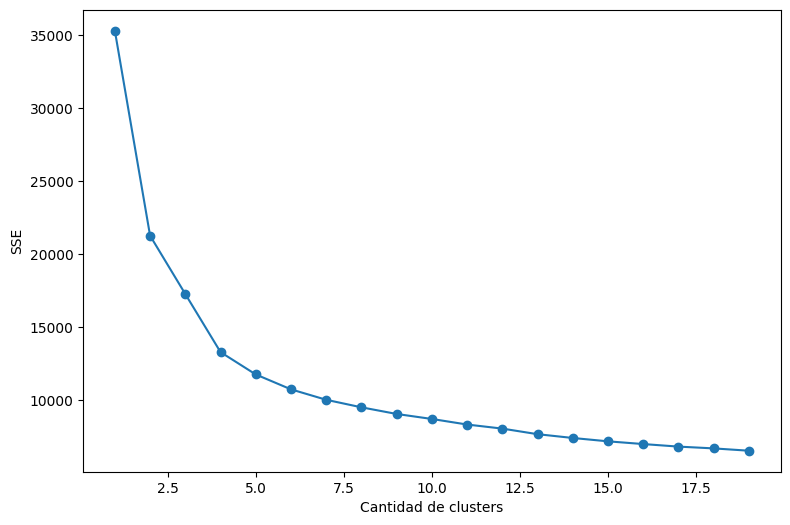

In [155]:
from sklearn.cluster import KMeans
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=k)
    km.fit(zona_kmeans_concat_df)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(9, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

### Mejor k encotrado k = 2 es para nosotros.


In [156]:
labels = KMeans(2, random_state=3).fit_predict(zona_kmeans_concat_df)

labels

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

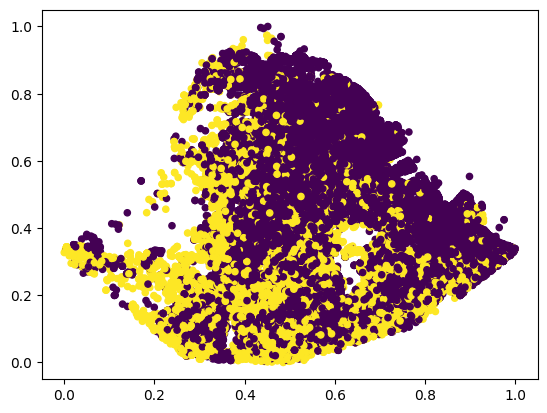

In [157]:
plt.scatter(zona_kmeans_concat_df['latitud'], zona_kmeans_concat_df['longitud'], c=labels, s=20, cmap='viridis')
plt.show()

### Metrica de los primeros 5 ks

In [158]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(zona_kmeans_concat_df)

    score = silhouette_score (zona_kmeans_concat_df, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.5645008
For n_clusters =3 silhouette score is 0.26233315
For n_clusters =4 silhouette score is 0.29232055


KeyboardInterrupt: 

### Gráfico con k= en un mapa de la Ciudad Autónoma de Buenos Aires.

##### Añadir las etiquetas de cluster al DataFrame

In [ ]:
zona_kmeans_concat_df_tres = zona_kmeans_concat_df.copy()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=3)
zona_kmeans_concat_df['cluster'] = kmeans.fit_predict(zona_kmeans_concat_df)

###### Desnormalizo las columnas latitud y longitud

In [ ]:
zona_kmeans_concat_df['latitud'] = zona_save_col_df['latitud']
zona_kmeans_concat_df['longitud'] = zona_save_col_df['longitud']

In [ ]:
zona_kmeans_concat_df['cluster'] = zona_kmeans_concat_df['cluster'].replace({0: 'grupo_0', 1: 'grupo_1'})

In [ ]:
zona_kmeans_concat_df

##### Grafico

In [ ]:
# Creamos una geometría Point para cada punto de latitud y longitud
geometry = [Point(xy) for xy in zip(zona_kmeans_concat_df['longitud'], zona_kmeans_concat_df['latitud'])]


# Creamos un GeoDataFrame con los datos y la geometría
gdf_clusters = gpd.GeoDataFrame(zona_kmeans_concat_df, geometry=geometry)


# Descargamos los datos geoespaciales de Buenos Aires
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)


# Filtramos solo los barrios de la Ciudad Autónoma de Buenos Aires
gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]


# Creamos el mapa base de Buenos Aires
fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')


# Graficamos los puntos de latitud y longitud coloreados por cluster
gdf_clusters.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, legend=True)

# Agregamos etiquetas a los barrios
for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)


# Configuramos el aspecto del mapa
ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
#Agregamos cuadrícula
ax.grid(True)

plt.show()

In [ ]:
# Asignamos colores a los diferentes valores de la columna "cluster"
colores = {'grupo_0': '#fde725', 'grupo_1': '#440154'}

# Utilizamos el parámetro "hue" para asignar los colores en base a la columna "cluster"
sns.pairplot(zona_kmeans_concat_df, height=2, hue="cluster", palette=colores)

### Ahora hacemos los gráficos para k=*3*

In [ ]:
labels = KMeans(3, random_state=3).fit_predict(zona_kmeans_concat_df_tres)

In [ ]:
plt.scatter(zona_kmeans_concat_df_tres['latitud'], zona_kmeans_concat_df_tres['longitud'], c=labels, s=20, cmap='viridis')
plt.show()

In [ ]:
zona_kmeans_concat_df_tres['cluster'] = labels

In [ ]:
zona_kmeans_concat_df_tres['latitud'] = zona_save_col_df['latitud']
zona_kmeans_concat_df_tres['longitud'] = zona_save_col_df['longitud']

In [ ]:
zona_kmeans_concat_df_tres['cluster'] = zona_kmeans_concat_df_tres['cluster'].replace({0: 'grupo_0', 1: 'grupo_1', 2: 'grupo_2'})

In [ ]:
geometry = [Point(xy) for xy in zip(zona_kmeans_concat_df_tres['longitud'], zona_kmeans_concat_df_tres['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_kmeans_concat_df_tres, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)

gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()

Sin One Hot Encode

In [ ]:
zona_kmeans_concat_df.columns

In [ ]:
zona_kmeans_concat_df_sin_OHC = zona_kmeans_concat_df.copy()

In [ ]:
columnas_a_eliminar_concat_sin_OHC = ["property_type_Casa", "property_type_Departamento", "property_type_PH", "cluster"]
zona_kmeans_concat_df_sin_OHC = zona_kmeans_concat_df_sin_OHC.drop(columnas_a_eliminar_concat_sin_OHC, axis=1)

In [ ]:
from sklearn.cluster import KMeans
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=k)
    km.fit(zona_kmeans_concat_df_sin_OHC)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(9, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(zona_kmeans_concat_df_sin_OHC)

    score = silhouette_score (zona_kmeans_concat_df_sin_OHC, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

In [ ]:
labels = KMeans(2, random_state=3).fit_predict(zona_kmeans_concat_df_sin_OHC)

In [ ]:
zona_kmeans_concat_df_sin_OHC['cluster'] = labels

In [ ]:
zona_kmeans_concat_df_sin_OHC['latitud'] = zona_save_col_df['latitud']
zona_kmeans_concat_df_sin_OHC['longitud'] = zona_save_col_df['longitud']

In [ ]:
zona_kmeans_concat_df_sin_OHC['cluster'] = zona_kmeans_concat_df_sin_OHC['cluster'].replace({0: 'grupo_0', 1: 'grupo_1', 2: 'grupo_2'})

In [ ]:
geometry = [Point(xy) for xy in zip(zona_kmeans_concat_df_sin_OHC['longitud'], zona_kmeans_concat_df_sin_OHC['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_kmeans_concat_df_sin_OHC, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)

gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()

# Clasificación

En esta sección vamos a otorgarle a cada propiedad, un tipo de precio; bajo, medio, alto. Vamos a intentar predecir dicho parámetro estudiando primero, el precio por metro cuadrado.


In [159]:
zona_df = pd.read_csv(train_preprocesado_y_outlier_XY_url)

#Creamos la columna pxm2 dividiendo el precio de cada propiedad por su superficie total. Nos toca ahora hacer las distintas asignaciones
zona_df["pxm2"] = [p / m for p, m in zip(zona_df["property_price"], zona_df["property_surface_total"])]
#zona_df

##Gráficos.

Ahora, vamos a graficar la distribución del precio por metro cuadrado en general y por tipo de propiedad.

[Text(0.5, 1.0, 'Distribución de precio por metro cuadrado'),
 Text(0.5, 0, 'Precio por metro cuadrado (USD)'),
 Text(0, 0.5, 'Cantidad publicaciones')]

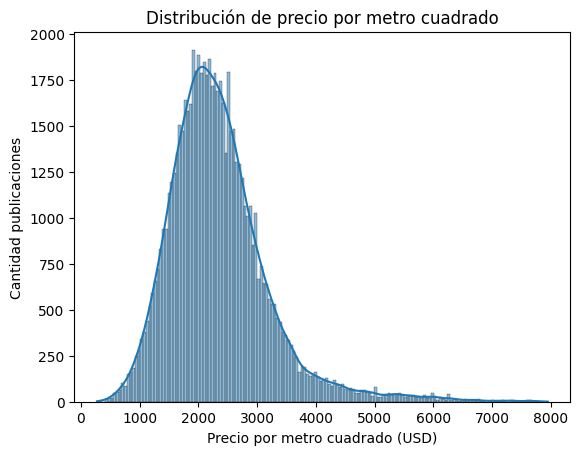

In [160]:
sns.histplot(data=zona_df["pxm2"], kde=True, alpha = 0.5).set(title="Distribución de precio por metro cuadrado",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")

Ahora, vamos a ver cómo cambia según el tipo de propiedad:


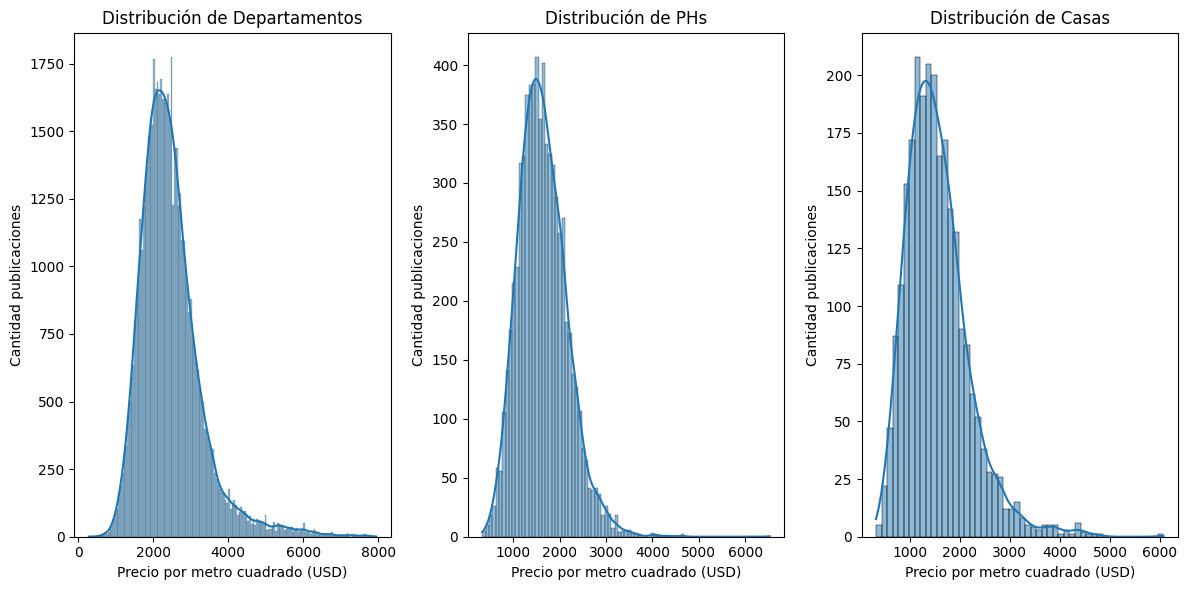

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(data=zona_df[(zona_df["property_type"]) == "Departamento"]["pxm2"], kde=True, alpha = 0.5, ax=axes[0]).set(title="Distribución de Departamentos",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "PH"]["pxm2"], kde=True, alpha = 0.5, ax=axes[1]).set(title="Distribución de PHs",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "Casa"]["pxm2"], kde=True, alpha = 0.5, ax=axes[2]).set(title="Distribución de Casas",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
plt.tight_layout()
plt.show()

## Variable *tipo_precio*

Vamos a dividir nuestro dataset y asignar a cada división, una etiqueta según el precio publicado. Las etiquetas serán Bajo, Medio, Alto. En primera instancia será una división equitativa, luego serán 25%, 50% y 25% y para lo último haremos ese mismo análisis discriminando por tipo de propiedad.

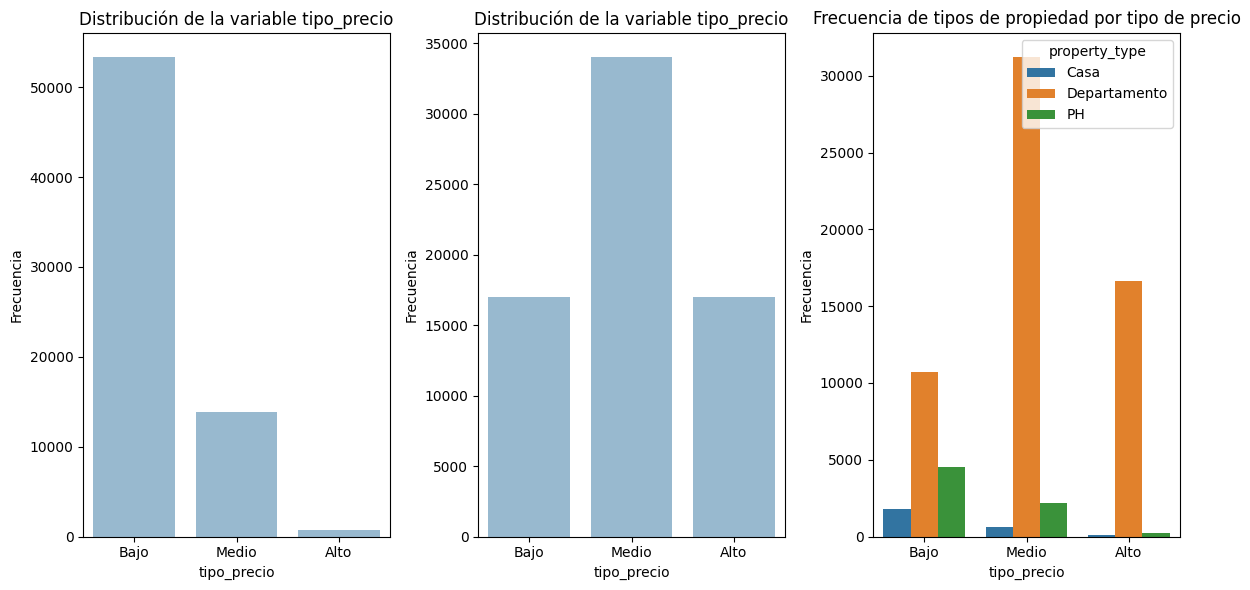

In [162]:
quantiles = [0, 0.25, 0.75, 1]
labels_nombres = ['Bajo', 'Medio', 'Alto']
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

zona_df['tipo_precio'] = pd.cut(zona_df['pxm2'], bins=3, labels=labels_nombres)
df_agrupado_Tprecio1 = zona_df.groupby(["tipo_precio"]).count()

zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
df_agrupado_Tprecio3 = zona_df.groupby(["tipo_precio", "property_type"]).size().reset_index(name='count')

zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

eje_x1 = df_agrupado_Tprecio1["pxm2"].tolist()
eje_y1 = df_agrupado_Tprecio1.index.tolist()
eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
eje_y2 = df_agrupado_Tprecio2.index.tolist()

#cambio x por y para hacer el gráfico vertical

sns.barplot(y=eje_x1, x=eje_y1, data=df_agrupado_Tprecio1 ,alpha=0.5, ax = axes[0]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax = axes[1]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(data=df_agrupado_Tprecio3, x='tipo_precio', y='count', hue='property_type', ax = axes[2]).\
  set(title="Frecuencia de tipos de propiedad por tipo de precio",ylabel='Frecuencia',xlabel='tipo_precio')

plt.tight_layout()
plt.show()

Con estas visualizaciones, se nos hace más fácil entender la distribución de los precios en las propiedades. Elegimos la representación 2 (la de tres intervalos divididos por cuartiles) como la mejor opción para trabajar porque:
* A diferencia de la 1, no es sensible a que las categorías sean muy pequeñas por la existencia de escasas propiedades muy caras (se puede ver la gran diferencia de la cantidad de propiedades de peso "alto" comparado a las otras)
* A diferencia de la 3, podremos usar el tipo de propiedad como un atributo que nos ayudará a predecir el rango de precio en el que una propiedad podría estar

Añadimos tipo_precio al conjunto de Test:

In [163]:
limite_bajo_medio = np.quantile(zona_df['pxm2'], 0.25)
limite_bajo_medio

1793.4782608695652

In [164]:
limite_medio_alto = np.quantile(zona_df['pxm2'], 0.75)
limite_medio_alto

2738.095238095238

In [165]:
x_test_y_test["pxm2"] = [p / m for p, m in zip(x_test_y_test["property_price"], x_test_y_test["property_surface_total"])]
x_test_y_test.loc[x_test_y_test["pxm2"] <= limite_bajo_medio, 'tipo_precio'] = "Bajo"
x_test_y_test.loc[(x_test_y_test["pxm2"] > limite_bajo_medio) & (x_test_y_test["pxm2"] <= limite_medio_alto), 'tipo_precio'] = "Medio"
x_test_y_test.loc[x_test_y_test["pxm2"] > limite_medio_alto, 'tipo_precio'] = "Alto"

x_test_y_test.head(3)

start_date    end_date    latitud   longitud    place_l3 property_type  \
77979  2021-09-07  2022-03-06 -34.572507 -58.447047  Colegiales  Departamento   
4228   2021-10-01  2022-02-09 -34.599391 -58.372185      Retiro  Departamento   
10233  2021-09-22  2022-03-09 -34.576547 -58.431213     Palermo  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
77979             3.0                2.0                    65.0   
4228              3.0                2.0                    51.0   
10233             4.0                3.0                    89.0   

       property_surface_covered  \
77979                      56.0   
4228                       51.0   
10233                      81.0   

                                          property_title  property_price  \
77979  3 ambientes con vista totalmente abierta . Ent...        248000.0   
4228           Depto venta 3 amb 51m2 Retiro OPORTUNIDAD         85000.0   
10233  Excelente departamento 4 ambientes, piso alto,...        240000.0   

       property_coverage_percent         pxm2 tipo_precio  
77979                  86.153846  3815.384615        Alto  
4228                  100.000000  1666.666667        Bajo  
10233                  91.011236  2696.629213       Medio

In [166]:
geometry = [Point(xy) for xy in zip(zona_df['longitud'], zona_df['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_df, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)



<ipython-input-167-495896f43842>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):


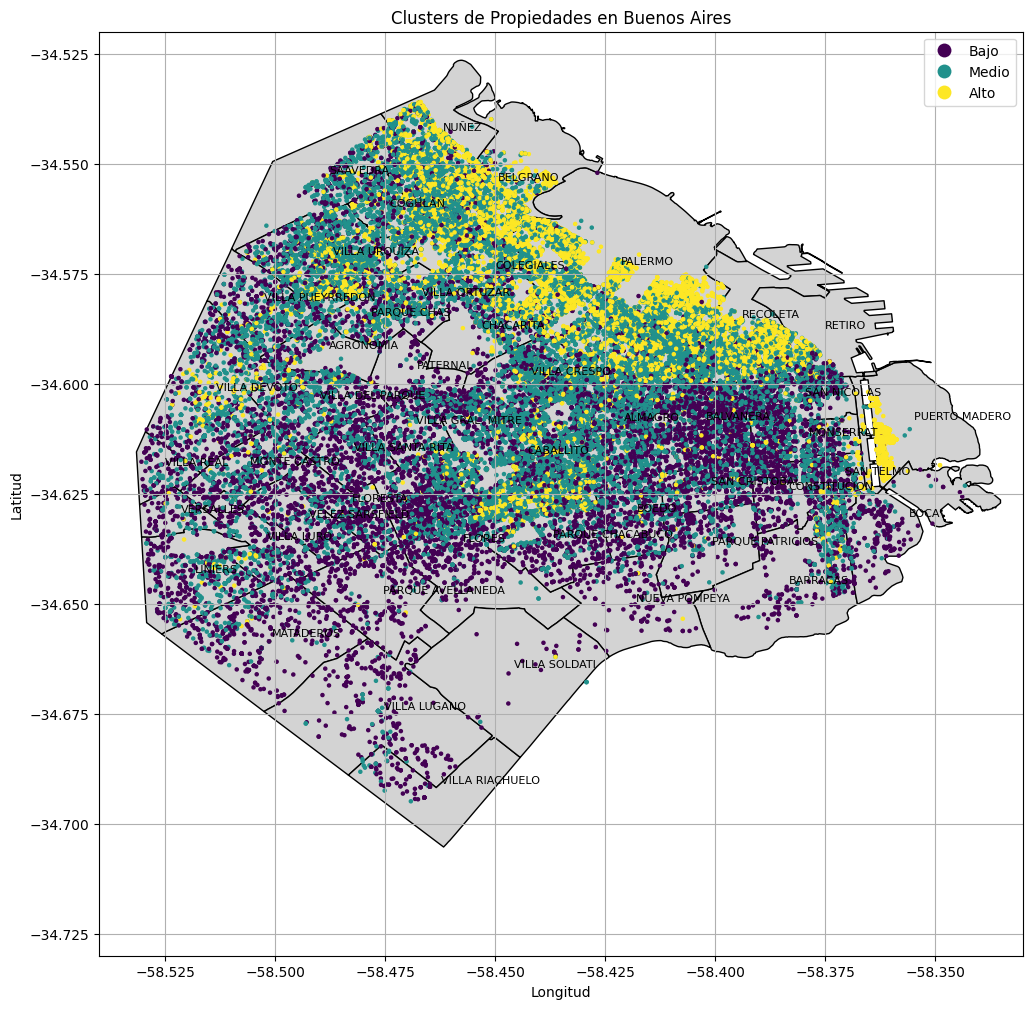

In [167]:
gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='tipo_precio', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()

## Random Forest

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [169]:
zona_df.head(1)

start_date    end_date    latitud   longitud          place_l3  \
0  2021-02-11  2021-03-18 -34.630337 -58.411793  Parque Patricios   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0  Departamento             2.0                1.0                   139.0   

   property_surface_covered  \
0                      61.0   

                                      property_title  property_price  \
0  VENTA DEPARTAMENTO 2 AMBIENTES CON TERRAZA PRO...        160000.0   

   año_publicacion  property_coverage_percent         pxm2 tipo_precio  
0                3                  43.884892  1151.079137        Bajo

In [170]:
x_test_y_test.head(1)

start_date    end_date    latitud   longitud    place_l3 property_type  \
77979  2021-09-07  2022-03-06 -34.572507 -58.447047  Colegiales  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
77979             3.0                2.0                    65.0   

       property_surface_covered  \
77979                      56.0   

                                          property_title  property_price  \
77979  3 ambientes con vista totalmente abierta . Ent...        248000.0   

       property_coverage_percent         pxm2 tipo_precio  
77979                  86.153846  3815.384615        Alto

In [171]:
df_randomforest = pd.get_dummies(zona_df, columns=["property_type"])
df_randomforest = df_randomforest.drop(columns=["año_publicacion",
                                                "start_date",
                                                "end_date",
                                                "place_l3",
                                                "property_title",
                                                "pxm2",
                                                "property_price",
                                                "property_type_Casa" #Se elimina los dummies manualmente para que coincida con los de test
                                                ])


rf_test = pd.get_dummies(x_test_y_test, columns=["property_type"])
rf_test = rf_test.drop(columns=["start_date",
                                "end_date",
                                "place_l3",
                                "property_title",
                                "pxm2",
                                "property_price",
                                "property_type_Casa" #Se elimina los dummies manualmente para que coincida con los de train
                                ])

df_randomforest.head(1)

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.630337 -58.411793             2.0                1.0   

   property_surface_total  property_surface_covered  \
0                   139.0                      61.0   

   property_coverage_percent tipo_precio  property_type_Departamento  \
0                  43.884892        Bajo                        True   

   property_type_PH  
0             False

In [172]:
rf_test.head(1)

latitud   longitud  property_rooms  property_bedrooms  \
77979 -34.572507 -58.447047             3.0                2.0   

       property_surface_total  property_surface_covered  \
77979                    65.0                      56.0   

       property_coverage_percent tipo_precio  property_type_Departamento  \
77979                  86.153846        Alto                        True   

       property_type_PH  
77979             False

In [173]:
rf_x_train = df_randomforest.drop(columns=["tipo_precio"])
rf_y_train = df_randomforest[["tipo_precio"]]

rf_x_train.head(1)

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.630337 -58.411793             2.0                1.0   

   property_surface_total  property_surface_covered  \
0                   139.0                      61.0   

   property_coverage_percent  property_type_Departamento  property_type_PH  
0                  43.884892                        True             False

In [174]:
rf_y_train.head(1)

tipo_precio
0        Bajo

In [175]:
rf_x_test = rf_test.drop(columns=["tipo_precio"])
rf_y_test = rf_test[["tipo_precio"]]

rf_x_test.head(1)

latitud   longitud  property_rooms  property_bedrooms  \
77979 -34.572507 -58.447047             3.0                2.0   

       property_surface_total  property_surface_covered  \
77979                    65.0                      56.0   

       property_coverage_percent  property_type_Departamento  property_type_PH  
77979                  86.153846                        True             False

In [176]:
rf_y_test.head(1)

tipo_precio
77979        Alto

Creamos el clasificador y tratamos de optimizarlo con Grid Search Cross Validation con 5 Folds, y tendremos en cuenta las métricas de Accuracy, F1 ponderado (una versión de F1 para predicciones de múltiples clases desbalanceadas) y Balanced Accuracy (una versión de Accuracy para predicciones de múltiples clases desbalanceadas). Variaremos los parámetros de criterio, cantidad de estimadores, y otros parámetros que controlan los splits de los nodos.

In [177]:
rf_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=52, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 2],
               "min_samples_split" : [3, 4, 5],
               "n_estimators": [20, 30, 50] }

metricas = ['accuracy', 'f1_weighted', 'balanced_accuracy']

gs = GridSearchCV(estimator=rf_cv,
                  param_grid=param_grid,
                  scoring=metricas,
                  refit=False,
                  cv=5,
                  n_jobs=-1)

gs_fit = gs.fit(X=rf_x_train, y=rf_y_train)

Graficamos los resultados de las métricas

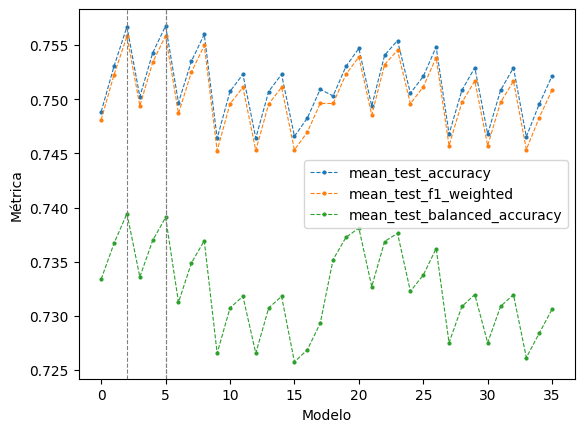

In [178]:
labels = [ key for key in gs_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)

plt.legend(labels)

for k in labels:
    x_linea = np.argmax(gs_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')

plt.xlabel("Modelo", fontsize=10)
plt.ylabel("Métrica", fontsize=10)
plt.show()

In [179]:
print("Accuracy en modelo con mejor Accuracy:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_accuracy'])])
print("Accuracy en modelo con mejor F1 Weighted:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_f1_weighted'])])
print("Accuracy en modelo con mejor Balanced Accuracy:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_balanced_accuracy'])])

Accuracy en modelo con mejor Accuracy: 0.7567647654034971
Accuracy en modelo con mejor F1 Weighted: 0.7567647654034971
Accuracy en modelo con mejor Balanced Accuracy: 0.7566912576164351


Elegimos el modelo con mejor Balanced Accuracy ya que maximiza equitativamente todas las métricas (como se puede apreciar en el gráfico) sin perder mucho Accuracy (que es la métrica que más queremos maximizar)

In [180]:
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_balanced_accuracy'])]
params_elegidos

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 50}

Realizamos la predicción

In [181]:
#Creamos un clasificador RF
rfc = RandomForestClassifier(criterion=params_elegidos['criterion'],
                             min_samples_leaf=params_elegidos['min_samples_leaf'],
                             min_samples_split=params_elegidos['min_samples_split'],
                             n_estimators=params_elegidos['n_estimators'],
                             max_features='sqrt', oob_score=True, random_state=52, n_jobs=-1)
#Entrenamos un modelo
model_rfc= rfc.fit(X = rf_x_train, y = rf_y_train)

#Hacemos una predicción
y_pred_model_rfc = model_rfc.predict(rf_x_test)

<ipython-input-181-39447fab8800>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfc= rfc.fit(X = rf_x_train, y = rf_y_train)


In [182]:
y_pred_model_rfc

array(['Alto', 'Medio', 'Medio', ..., 'Alto', 'Medio', 'Alto'],
      dtype=object)

In [183]:
rf_y_test.to_numpy()

array([['Alto'],
       ['Bajo'],
       ['Medio'],
       ...,
       ['Alto'],
       ['Medio'],
       ['Alto']], dtype=object)

              precision    recall  f1-score   support

        Alto      0.783     0.702     0.740      4560
        Bajo      0.801     0.745     0.772      4679
       Medio      0.745     0.814     0.778      8629

    accuracy                          0.767     17868
   macro avg      0.776     0.754     0.763     17868
weighted avg      0.769     0.767     0.767     17868



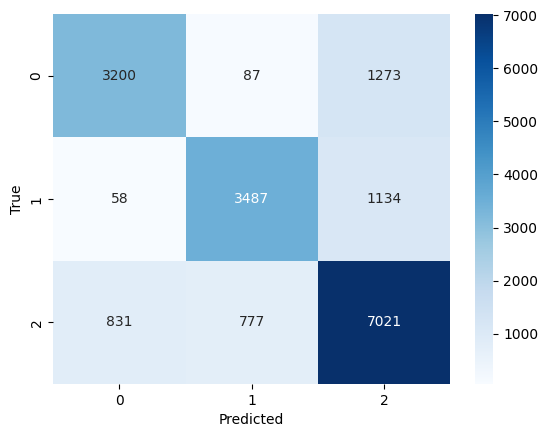

In [184]:
#Matriz de Confusión
cm = confusion_matrix(rf_y_test,y_pred_model_rfc)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(rf_y_test, y_pred_model_rfc, digits=3))

Podemos ver que la Accuracy y el F1 Weighted durante el Testing fueron ligeramente mejores (Ambos alrededor del 76.7%) que los de Training con Cross Validation (Ambos alrededor del 75.5%).

Por otro lado, durante el Testing, la categoría mejor predicha del Target (según f1-score) fue la de propiedades de valor Medio, mientras que la peor fue la de propiedades de valor Alto

Estos son los atributos más importantes:

In [185]:
sorted(list(zip(rf_x_train.columns.to_list(), model_rfc.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.28638224864823836),
 ('longitud', 0.2392016854948832),
 ('property_coverage_percent', 0.13140981149567793),
 ('property_surface_total', 0.12474418959339117),
 ('property_surface_covered', 0.11799144305440587),
 ('property_type_Departamento', 0.03818702706914719),
 ('property_rooms', 0.026040941380275674),
 ('property_type_PH', 0.01970223390891316),
 ('property_bedrooms', 0.016340419355067328)]

Podemos ver que, por gran diferencia, Latitud y Longitud son los atributos más importantes, seguido de Superficie Cubierta, Total, y la relación porcentual entre ellas

Graficamos uno de los árboles (ya que es extenso graficaremos solo los 4 primero niveles):

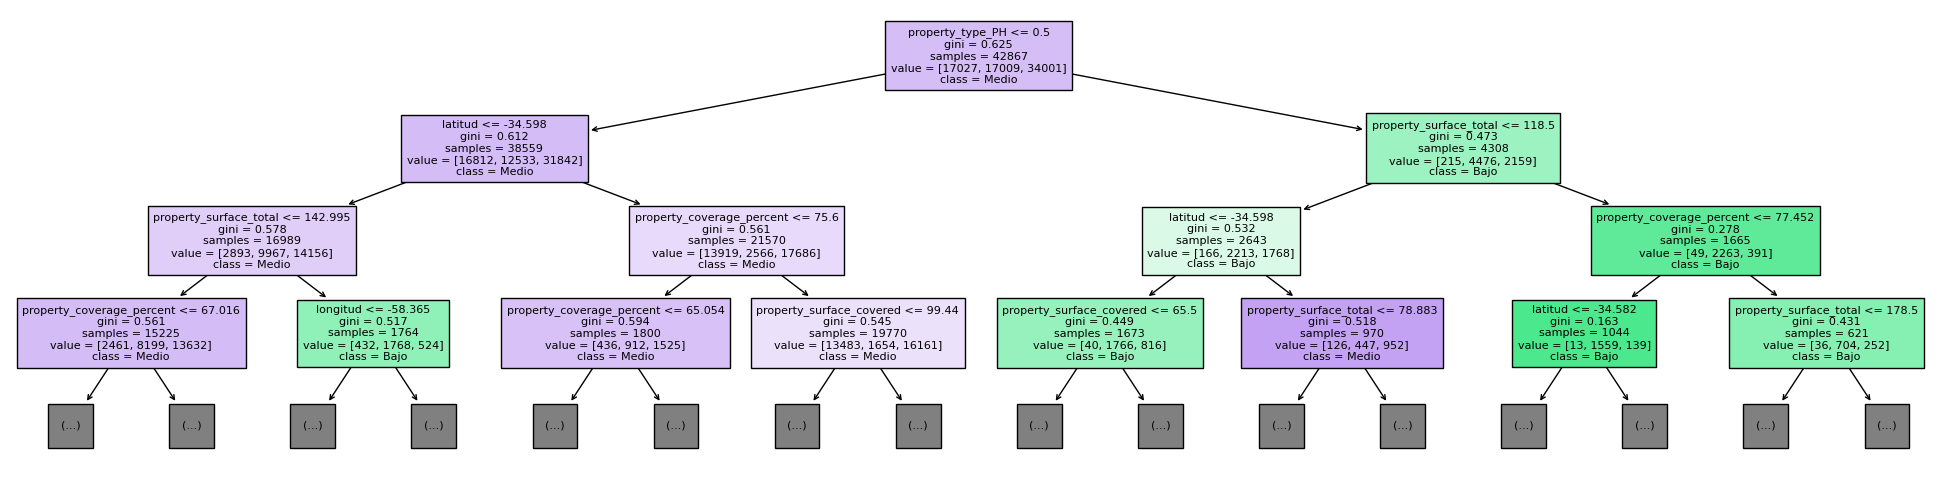

In [186]:
plt.figure(figsize=(25,6))

tree_plot_completo=tree.plot_tree(model_rfc.estimators_[25],
                                 max_depth=3,
                                 feature_names=rf_x_train.columns.to_list(),
                                 filled=True,
                                 rounded=False,
                                 class_names=model_rfc.classes_,
                                 fontsize=8)
plt.show(tree_plot_completo)

Podemos ver que, a diferencia de lo que sugiere la lista de atributos importantes, este árbol decidió tener como raíz al atributo categórico property_type_PH, partiendo el conjunto en 2 ramas: una con Propiedades Horizontales, y la otra con Casas y Departamentos.

A partir de ello, los siguientes niveles utilizaron diversas combinaciones de atributos calificados como importantes, tales como: Superficie Total/Cubierta, Porcentaje de Superficie Cubierta y Latitud/Longitud

## GradientBoosting

In [187]:
from sklearn.ensemble import GradientBoostingClassifier

In [188]:
df_gbc = pd.get_dummies(zona_df, columns=["property_type"])
df_gbc = df_gbc.drop(columns=["año_publicacion",
                              "start_date",
                              "end_date",
                              "place_l3",
                              "property_title",
                              "pxm2",
                              "property_price",
                              "property_type_Casa" #Se elimina los dummies manualmente para que coincida con los de test
                              ])


gbc_test = pd.get_dummies(x_test_y_test, columns=["property_type"])
gbc_test = gbc_test.drop(columns=["start_date",
                                  "end_date",
                                  "place_l3",
                                  "property_title",
                                  "pxm2",
                                  "property_price",
                                  "property_type_Casa" #Se elimina los dummies manualmente para que coincida con los de train
                                  ])

In [189]:
gbc_x_train = df_gbc.drop(columns=["tipo_precio"])
gbc_y_train = df_gbc[["tipo_precio"]]

gbc_x_test = gbc_test.drop(columns=["tipo_precio"])
gbc_y_test = gbc_test[["tipo_precio"]]

Creamos el clasificador y tratamos de optimizarlo con Grid Search Cross Validation con 5 Folds, y tendremos en cuenta las métricas de Accuracy, F1 ponderado (una versión de F1 para predicciones de múltiples clases desbalanceadas) y Balanced Accuracy (una versión de Accuracy para predicciones de múltiples clases desbalanceadas). Variaremos el parámetro de learning_rate.

In [190]:
gbc_cv = GradientBoostingClassifier(random_state=52, n_estimators=125)

param_grid = { "learning_rate" : [0.5, 0.7, 0.9]}

metricas = ['accuracy', 'f1_weighted', 'balanced_accuracy']

gs = GridSearchCV(estimator=gbc_cv,
                  param_grid=param_grid,
                  scoring=metricas,
                  refit=False,
                  cv=5,
                  n_jobs=-1)

gs_fit = gs.fit(X=gbc_x_train, y=gbc_y_train)

KeyboardInterrupt: 

Graficamos los resultados de las métricas

In [ ]:
labels = [ key for key in gs_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)

plt.legend(labels)

for k in labels:
    x_linea = np.argmax(gs_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')

plt.xlabel("Modelo", fontsize=10)
plt.ylabel("Métrica", fontsize=10)
plt.show()

In [ ]:
print("Accuracy en modelo con mejor Accuracy:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_accuracy'])])
print("Accuracy en modelo con mejor F1 Weighted:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_f1_weighted'])])
print("Accuracy en modelo con mejor Balanced Accuracy:", gs_fit.cv_results_['mean_test_accuracy'][np.argmax(gs_fit.cv_results_['mean_test_balanced_accuracy'])])

Elegimos el modelo con mejor Balanced Accuracy ya que maximiza equitativamente todas las métricas (como se puede apreciar en el gráfico) sin perder mucho Accuracy (que es la métrica que más queremos maximizar)

In [ ]:
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_balanced_accuracy'])]
params_elegidos

Realizamos la predicción

In [ ]:
#Creamos un clasificador RF
gbc = GradientBoostingClassifier(learning_rate=params_elegidos['learning_rate'],
                                 random_state=52)
#Entrenamos un modelo
model_gbc= gbc.fit(X = gbc_x_train, y = gbc_y_train)

#Hacemos una predicción
y_pred_model_gbc = model_gbc.predict(gbc_x_test)

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(gbc_y_test,y_pred_model_gbc)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(gbc_y_test, y_pred_model_gbc, digits=3))

Podemos ver que la Accuracy y el F1 Weighted durante el Testing fueron bastante similares a los de Training con Cross Validation (Alrededor del 69.5%).

Por otro lado, durante el Testing, la categoría mejor predicha del Target (según f1-score) fue la de propiedades de valor Medio, mientras que la peor fue la de propiedades de valor Alto

#Regresion




## *Modelo de Knn*

Se busca predecir el precio

In [ ]:
X = df_deptos[[ 'latitud' , 'longitud' ,'property_bedrooms', 'property_rooms', 'property_surface_total', 'property_surface_covered', 'año_publicacion', 'property_coverage_percent']]

Y = df_deptos[['property_price']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=12)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [ ]:
print("Datos de entrenamiento normalizados:\n", X_train_scaled)
print("Datos de prueba normalizados:\n", X_test_scaled)

Ya se tiene los datos normalizado

In [ ]:
knn = KNeighborsRegressor()


param_grid = {'n_neighbors': np.arange(1, 25),
             'weights': ['uniform', 'distance'],
              'algorithm':['ball_tree', 'kd_tree'],
              'metric':['euclidean','manhattan']}

knn_gscv = GridSearchCV(knn, param_grid, cv=3)

knn_gscv.fit(X_train_scaled, y_train)


print("Mejores hiperparámetros: ", knn_gscv.best_params_)
print("Mejor métrica: ", knn_gscv.best_score_)

knn_model = knn_gscv.best_estimator_
model = knn_model.fit(X = X_train_scaled, y = y_train)
precios_predichos_knn = model.predict(X_test_scaled)

In [ ]:
gb_model = knn_model
model = gb_model.fit(X = X_train_scaled, y = y_train)
precios_predichos_gb = model.predict(X_train_scaled)

precios_predichos_knn = knn_gscv.predict(X_test_scaled)

# Calcular el MSE entre las predicciones y los valores reales
mse = mean_squared_error(y_test, precios_predichos_knn)
print("Error Cuadrático Medio (MSE):", mse)

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, precios_predichos_knn)


print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Error (MAE): ", mae)



```
# Ahora me fijo con el conjunto de entrenamiento
```



In [ ]:
precios_predichos_train = knn_gscv.predict(X_train_scaled)


mse_train = mean_squared_error(y_train, precios_predichos_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, precios_predichos_train)

print("Conjunto de Entrenamiento:")
print("Mean Squared Error (MSE): ", mse_train)
print("Root Mean Squared Error (RMSE): ", rmse_train)
print("Mean Absolute Error (MAE): ", mae_train)